# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

**You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer**. From a business perspective, **if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts **how much someone will spend based on demographics and offer type**. Or you could build a model that **predicts whether or not someone will respond to an offer**. Or, you don't need to build a machine learning model at all. You could **develop a set of heuristics that determine what offer you should send to each customer** (i.e., **75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A**).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### The charts requires the new version of the seaborn (0.11.2), run the below to install a new version and then restart the Kernel.
##### condat update pandas indicated in above screenshot runs for a long time and remained unfinished. so pip install is an option mentioned in one of the knowledge article and is what adopted here

In [2]:
# import sys
# !{sys.executable} -m pip install seaborn==0.11.2
# !{sys.executable} -m pip install -U scikit-learn
# #restart the kernel after installing the lastest version of seaborn

In [3]:
import pandas as pd
import numpy as np
import math
import datetime as datetime
import json
% matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import sklearn as sk

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error


from sklearn.utils.multiclass import unique_labels

from sklearn.preprocessing import MinMaxScaler

from platform import python_version

In [4]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [5]:
print("versions : pd={0}, sns={1}, numpy={2}, sklearn={3}, python={4}".
      format(pd.__version__ , sns.__version__ , np.version.version, sk.__version__, python_version() ))

versions : pd=0.23.3, sns=0.11.2, numpy=1.19.5, sklearn=0.24.2, python=3.6.3


In [6]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 0)

## Check the data in each of the three data files

In [7]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
print("portfolio shape {}, \nprofile shape {}, \ntranscript shape {}".format(portfolio.shape, profile.shape, transcript.shape))

portfolio shape (10, 6), 
profile shape (17000, 5), 
transcript shape (306534, 4)


## Portfolio: Analylze and Create Features

In [11]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [12]:
# find the unique channels in the portfolio
# portfolio.offer_type.unique()

x = set([c for ch in portfolio.channels for c in ch])
print("event count = {0}\nunique events are {1}".format(len(x), x))

event count = 4
unique events are {'web', 'mobile', 'social', 'email'}


In [13]:
# find channels

channelsList =[]
for ch in portfolio.channels:
    channelsList.extend(ch)
    
uniqueChannels = set(channelsList)
print(uniqueChannels)

{'web', 'mobile', 'social', 'email'}


In [14]:
# create separate columns for each of the channels

def getChannel(val):
    if (channel in val):
        return 1
    else:
        return 0

for channel in uniqueChannels:
    portfolio[channel] = portfolio['channels'].apply(getChannel)

portfolio

,channels,difficulty,duration,id,offer_type,reward,web,mobile,social,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [15]:
portfolio.index

RangeIndex(start=0, stop=10, step=1)

In [16]:
portfolio2 = pd.get_dummies(portfolio, columns=['offer_type'])
portfolio2 = portfolio2.join(portfolio[['offer_type' ]].set_index(portfolio['id']), on=portfolio2['id'])

# portfolio2['offer_type2'] = portfolio['offer_type']
# portfolio2.head()

In [17]:
portfolio2.drop(columns=['channels'], inplace=True)

In [18]:
portfolio2.head()

,difficulty,duration,id,reward,web,mobile,social,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,bogo
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0,bogo
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1,informational
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0,bogo
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0,discount


Text(0.5, 1.0, 'event count')

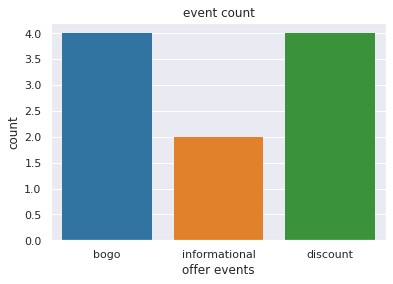

In [19]:
ax = plt.subplot()

plt.style.use('default')
# plt.grid(True, which='both')

sns.countplot(x='offer_type', 
            data = portfolio2
            )
ax.set_xlabel('offer events')

plt.title('event count')


## Profile: Analyze and Create Features

In [20]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [21]:
profile2 = pd.get_dummies(profile, columns=['gender'])
profile2 = profile2.join(profile[['gender']].set_index(profile['id']), on='id')


# make incomde zero where the value is null of NaN
profile2['income']=profile2['income'].fillna(0)

#create income group in increment of 10,000
profile2['income_group'] = (profile2['income'] // 10000) * 10000

#create age group in increment of 5
profile2['age_group'] = (profile2['age'] // 5) * 5

profile2['membership_date'] = pd.to_datetime(profile2['became_member_on'], format='%Y%m%d', errors='ignore')

profile2['membership_year'] = profile2['became_member_on']//10000
profile2['membership_month'] =(profile2['became_member_on'] % 10000) // 100
profile2['membership_day'] = profile2['became_member_on'] % 100

profile2['membership_yy_mm'] = profile2['became_member_on']//100


profile2.head()

,age,became_member_on,id,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm
0,118,20170212,68be06ca386d4c31939f3a4f0e3dd783,0.0,0,0,0,None,0.0,115,2017-02-12,2017,2,12,201702
1,55,20170715,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,F,110000.0,55,2017-07-15,2017,7,15,201707
2,118,20180712,38fe809add3b4fcf9315a9694bb96ff5,0.0,0,0,0,None,0.0,115,2018-07-12,2018,7,12,201807
3,75,20170509,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,F,100000.0,75,2017-05-09,2017,5,9,201705
4,118,20170804,a03223e636434f42ac4c3df47e8bac43,0.0,0,0,0,None,0.0,115,2017-08-04,2017,8,4,201708


In [22]:
profile2.isnull().sum()

age                 0   
became_member_on    0   
id                  0   
income              0   
gender_F            0   
gender_M            0   
gender_O            0   
gender              2175
income_group        0   
age_group           0   
membership_date     0   
membership_year     0   
membership_month    0   
membership_day      0   
membership_yy_mm    0   
dtype: int64

In [23]:
profile2[profile2['gender'].isnull()].groupby('age').count()

,became_member_on,id,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm
age,,,,,,,,,,,,,,
118,2175,2175,2175,2175,2175,2175,0,2175,2175,2175,2175,2175,2175,2175


In [24]:
profile2.shape

(17000, 15)

In [25]:
profile2.dropna(subset=['gender'], inplace=True)

In [26]:
profile2.shape

(14825, 15)

In [27]:
profile2.isnull().sum()

age                 0
became_member_on    0
id                  0
income              0
gender_F            0
gender_M            0
gender_O            0
gender              0
income_group        0
age_group           0
membership_date     0
membership_year     0
membership_month    0
membership_day      0
membership_yy_mm    0
dtype: int64

Text(0.5, 1.0, 'Gender distribution')

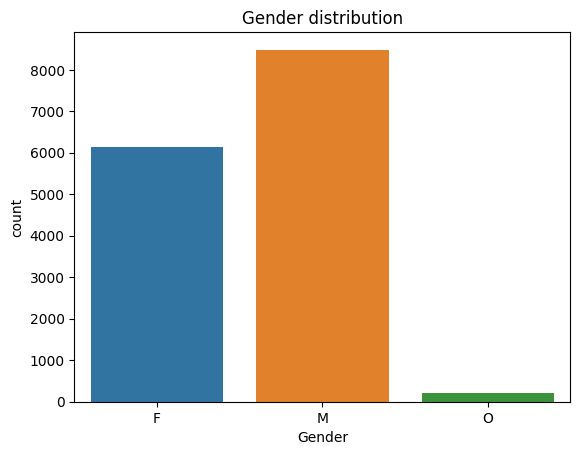

In [28]:
ax = plt.subplot()

plt.style.use('default')
# plt.grid(True, which='both')

sns.countplot(x='gender', 
            data = profile2
            )
ax.set_xlabel('Gender')

plt.title('Gender distribution')


In [29]:
profile2['income_group'].value_counts()

50000.0     2661
70000.0     2338
60000.0     2328
30000.0     1940
40000.0     1841
80000.0     1409
90000.0     1215
100000.0    575 
110000.0    505 
120000.0    13  
Name: income_group, dtype: int64

Text(0.5, 1.0, 'Income distribution')

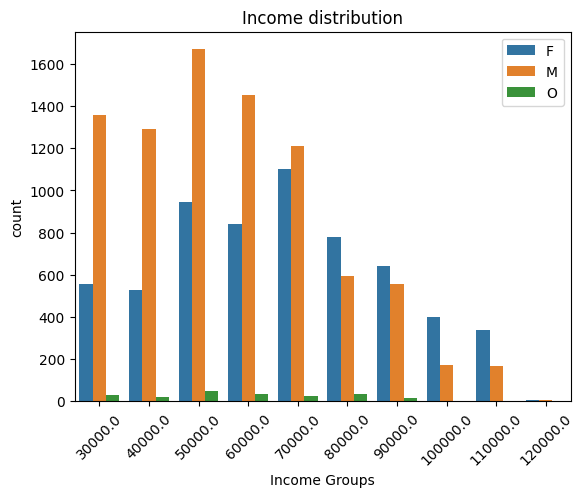

In [30]:
ax = plt.subplot()

plt.style.use('default')
# plt.grid(True, which='both')

sns.countplot(x='income_group', hue='gender',
            data = profile2
            )
ax.set_xlabel('Income Groups')
plt.xticks(rotation=45)
plt.legend(loc='upper right',fancybox=True )


plt.title('Income distribution')


## Transcript: Analyze and Create Features

In [31]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [32]:
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,"{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}"
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [33]:
x=transcript.event.unique()
print("event count = {0}\nunique events are {1}".format(len(x), x))

event count = 4
unique events are ['offer received' 'offer viewed' 'transaction' 'offer completed']


Text(0.5, 1.0, 'event count')

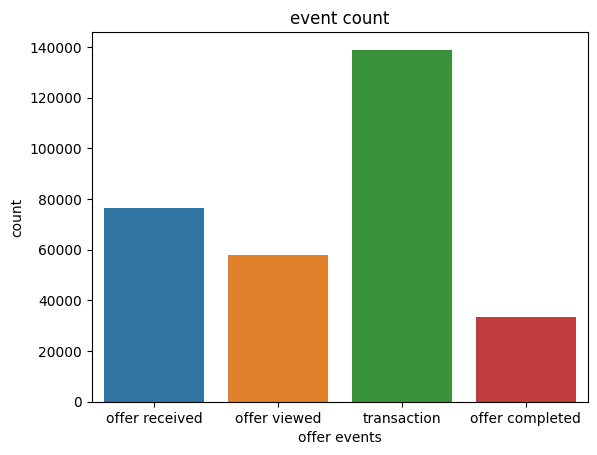

In [34]:
ax = plt.subplot()

plt.style.use('default')
# plt.grid(True, which='both')

sns.countplot(x='event', 
            data = transcript
            )
ax.set_xlabel('offer events')

plt.title('event count')


#### get unique keys from dictionary in values

In [35]:
keyslist =[]
for val in transcript['value']:
    for key in val.keys():
        keyslist.append(key)
        
set(keyslist)

{'amount', 'offer id', 'offer_id', 'reward'}

In [36]:
trans = transcript

def getOffer(dictval):
    if key in dictval:
        return dictval[key]
    else:
        return ""

for key in set(keyslist):
    trans[key] = transcript['value'].apply(getOffer)
    
trans.head()

,event,person,time,value,reward,amount,offer id,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},,,9b98b8c7a33c4b65b9aebfe6a799e6d9,
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},,,0b1e1539f2cc45b7b9fa7c272da2e1d7,
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},,,2906b810c7d4411798c6938adc9daaa5,
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},,,fafdcd668e3743c1bb461111dcafc2a4,
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},,,4d5c57ea9a6940dd891ad53e9dbe8da0,


#### check if columns "offer_id and "offer id" both has any value in a same row i.e., mutually exclusive

In [37]:
x= trans[(trans['offer_id'] != "") & (trans['offer id'] != "")].shape[0]
print("total rows having both offer_id and offer id = ", x)

total rows having both offer_id and offer id =  0


In [38]:
## create a single offer column from offer id and offer_id
trans['offer'] = trans['offer id'] + trans['offer_id']
trans.head()

,event,person,time,value,reward,amount,offer id,offer_id,offer
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},,,9b98b8c7a33c4b65b9aebfe6a799e6d9,,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},,,0b1e1539f2cc45b7b9fa7c272da2e1d7,,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},,,2906b810c7d4411798c6938adc9daaa5,,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},,,fafdcd668e3743c1bb461111dcafc2a4,,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},,,4d5c57ea9a6940dd891ad53e9dbe8da0,,4d5c57ea9a6940dd891ad53e9dbe8da0


#### check amount and reward columns and make a single column out of the two

In [39]:
#check if any rows has both reard and amount
trans[(trans['amount'] == "") & (trans['reward'] == "")].shape[0]

134002

In [40]:
# check reward values
trans[trans['reward'] != ""]['reward'].unique()#u

array([2, 5, 10, 3], dtype=object)

In [41]:
# create a new column by combining reward and amount columns
trans['reward_amt'] = trans['reward'].apply(lambda x: 0 if x =="" else x) + trans['amount'].apply(lambda x: 0 if x =="" else x)

In [42]:
# replacing null with 0 in both reward and amount columns

trans['reward'] = trans['reward'].apply(lambda x: 0 if x =="" else x)
trans['amount'] = trans['amount'].apply(lambda x: 0 if x =="" else x)
trans.head()

,event,person,time,value,reward,amount,offer id,offer_id,offer,reward_amt
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0.0,2906b810c7d4411798c6938adc9daaa5,,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0.0,fafdcd668e3743c1bb461111dcafc2a4,,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


#### create dummy columns into a new dataframe

In [43]:
trans['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [44]:
trans['event2'] = trans['event']

In [45]:
trans2 = pd.get_dummies(trans, columns=['event'])

In [46]:
trans2.head()

,person,time,value,reward,amount,offer id,offer_id,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,offer received,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,offer received,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0.0,2906b810c7d4411798c6938adc9daaa5,,2906b810c7d4411798c6938adc9daaa5,0.0,offer received,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0.0,fafdcd668e3743c1bb461111dcafc2a4,,fafdcd668e3743c1bb461111dcafc2a4,0.0,offer received,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,offer received,0,1,0,0


In [47]:
trans2.drop(columns = ['value', 'offer_id','offer id'], inplace=True)

In [48]:
trans2[trans2['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,offer received,0,1,0,0
15561,78afa995795e4d85b5d9ceeca43f5fef,6,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,offer viewed,0,0,1,0
47582,78afa995795e4d85b5d9ceeca43f5fef,132,0,19.89,,19.89,transaction,0,0,0,1
47583,78afa995795e4d85b5d9ceeca43f5fef,132,5,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.00,offer completed,1,0,0,0
49502,78afa995795e4d85b5d9ceeca43f5fef,144,0,17.78,,17.78,transaction,0,0,0,1
53176,78afa995795e4d85b5d9ceeca43f5fef,168,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.00,offer received,0,1,0,0
85291,78afa995795e4d85b5d9ceeca43f5fef,216,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.00,offer viewed,0,0,1,0
87134,78afa995795e4d85b5d9ceeca43f5fef,222,0,19.67,,19.67,transaction,0,0,0,1
92104,78afa995795e4d85b5d9ceeca43f5fef,240,0,29.72,,29.72,transaction,0,0,0,1
141566,78afa995795e4d85b5d9ceeca43f5fef,378,0,23.93,,23.93,transaction,0,0,0,1


In [49]:
trans2.columns

Index(['person', 'time', 'reward', 'amount', 'offer', 'reward_amt', 'event2',
       'event_offer completed', 'event_offer received', 'event_offer viewed',
       'event_transaction'],
      dtype='object')

In [50]:
trans2[(trans2['amount'] > 0 ) & (trans2['amount'] < 1)]

trans2[trans2['person'] == '02c083884c7d45b39cc68e1314fec56c']

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction
27,02c083884c7d45b39cc68e1314fec56c,0,0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,0.00,offer received,0,1,0,0
12653,02c083884c7d45b39cc68e1314fec56c,0,0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,0.00,offer viewed,0,0,1,0
12654,02c083884c7d45b39cc68e1314fec56c,0,0,0.83,,0.83,transaction,0,0,0,1
15565,02c083884c7d45b39cc68e1314fec56c,6,0,1.44,,1.44,transaction,0,0,0,1
18071,02c083884c7d45b39cc68e1314fec56c,12,0,4.56,,4.56,transaction,0,0,0,1
38222,02c083884c7d45b39cc68e1314fec56c,84,0,1.53,,1.53,transaction,0,0,0,1
39545,02c083884c7d45b39cc68e1314fec56c,90,0,0.50,,0.50,transaction,0,0,0,1
42030,02c083884c7d45b39cc68e1314fec56c,102,0,9.80,,9.80,transaction,0,0,0,1
47586,02c083884c7d45b39cc68e1314fec56c,132,0,4.10,,4.10,transaction,0,0,0,1
49505,02c083884c7d45b39cc68e1314fec56c,144,0,2.73,,2.73,transaction,0,0,0,1


## Join the two dataframe (Transactions and Portfolio) into a single dataframe

In [51]:
# profile2.head()

In [52]:
# portfolio2.head()

In [53]:
# trans2.head()

In [54]:
trans2[trans2['person'] == 'da7a7c0dcfcb41a8acc7864a53cf60fb']

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction
263150,da7a7c0dcfcb41a8acc7864a53cf60fb,582,0,0.35,,0.35,transaction,0,0,0,1


In [55]:
transcript[transcript['person'] == '0011e0d4e6b944f998e987f904e8c1e5']

,event,person,time,value,reward,amount,offer id,offer_id,offer,reward_amt,event2
3066,offer received,0011e0d4e6b944f998e987f904e8c1e5,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0.00,3f207df678b143eea3cee63160fa8bed,,3f207df678b143eea3cee63160fa8bed,0.00,offer received
16179,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,6,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,0.00,3f207df678b143eea3cee63160fa8bed,,3f207df678b143eea3cee63160fa8bed,0.00,offer viewed
47805,transaction,0011e0d4e6b944f998e987f904e8c1e5,132,{'amount': 13.49},0,13.49,,,,13.49,transaction
56298,offer received,0011e0d4e6b944f998e987f904e8c1e5,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,0.00,2298d6c36e964ae4a3e7e9706d1fb8c2,,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,offer received
75427,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,186,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,0.00,2298d6c36e964ae4a3e7e9706d1fb8c2,,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,offer viewed
95421,transaction,0011e0d4e6b944f998e987f904e8c1e5,252,{'amount': 11.93},0,11.93,,,,11.93,transaction
95422,offer completed,0011e0d4e6b944f998e987f904e8c1e5,252,"{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}",3,0.00,,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,3.00,offer completed
113919,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0.00,5a8bc65990b245e5a138643cd4eb9837,,5a8bc65990b245e5a138643cd4eb9837,0.00,offer received
133370,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,354,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,0.00,5a8bc65990b245e5a138643cd4eb9837,,5a8bc65990b245e5a138643cd4eb9837,0.00,offer viewed
153697,offer received,0011e0d4e6b944f998e987f904e8c1e5,408,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,offer received


In [56]:
#rename the id columns in the portfolio and profile dataframes

portfolio2.rename(columns={'id':'portfolio_id', 'reward': 'portfolio_reward'}, inplace=True)
profile2.rename(columns={'id':'profile_id'}, inplace=True)

In [57]:
# starbucksdf = trans2.join(profile2.set_index('profile_id'), on='person' ).join(portfolio2.set_index('portfolio_id'), on='offer')

In [58]:
trans_portfolio_df = trans2.join(portfolio2.set_index('portfolio_id'), on='offer')

###### data be sorted by 'offer received', 'offer viewed', 'transaction', 'offer completed' for each customer, to avoid cases where received or completed or transactions or viewed are at the same time, but order differently. There are few instances, where transaction is prior to the recieved and this ordering will ensure right sequence is in plance


In [59]:
#sort the dataframe in following sequence 'offer_received, offer_viewed, transaction, offer_completed'
# this is needed in a scenario where offer viewed and completed are at same time

def sortSeq(val):
    if (val == 'offer received'):
        sortseq = 1
    elif (val == 'offer viewed'):
        sortseq = 2
    elif (val == 'transaction'):
        sortseq = 3
    elif (val == 'offer completed'):
        sortseq = 4
    else:
        sortseq = 0
    
    return sortseq

# starbucksdf
trans_portfolio_df['sort_seq'] = trans_portfolio_df['event2'].apply(sortSeq)

In [60]:
# starbucksdf
trans_portfolio_df.sort_values(by=['person','time', 'sort_seq'], inplace=True)

In [61]:
# starbucksdf
trans_portfolio_df.head()

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,portfolio_reward,web,mobile,social,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,sort_seq
55972,0009655768c64bdeb2e877511632db8f,168,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.00,offer received,0,1,0,0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,informational,1
77705,0009655768c64bdeb2e877511632db8f,192,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.00,offer viewed,0,0,1,0,0.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,informational,2
89291,0009655768c64bdeb2e877511632db8f,228,0,22.16,,22.16,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
113605,0009655768c64bdeb2e877511632db8f,336,0,0.00,3f207df678b143eea3cee63160fa8bed,0.00,offer received,0,1,0,0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,informational,1
139992,0009655768c64bdeb2e877511632db8f,372,0,0.00,3f207df678b143eea3cee63160fa8bed,0.00,offer viewed,0,0,1,0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,informational,2


In [62]:
# starbucksdf[starbucksdf['person']=='da7a7c0dcfcb41a8acc7864a53cf60fb']

#### in order to analyze the offer and its effectiveness, we need to associate transactions with the offer. in the current dataset, transaction do not have an association with the offer.

#### Its given in problem statement, that offer regardless of being viewed, will influence the buying behavior (transactions) during the validity of the offer. To accomplish that, 
##### 1. for each offer received row, we create additional columns that reflects the validity of that offer. Using fillna, we fill in the null values for transactions, and offer-completed, offer-viewed. 
##### 2. we then compare the transaction time if it falls within the offer validity period. if so, we call it 'offer influence yes', otherwise 'offer influence no'. 
##### 3. we also have instances where person has not received any offer, we terms them as ' no offer



###### first, lets check if there are any person who have never received any offer and have transactions

In [63]:

ofr_rcvd = trans_portfolio_df[trans_portfolio_df['event_offer received'] == 1]
ofr_rcvd

all_persons= set(profile['id'].values)
person_with_offers = set(ofr_rcvd['person'].values)
person_wo_offer =list(all_persons.difference(person_with_offers))
print("Number of persons in profile table that have not received any offer {0}\n\n{1} ".format(len(person_wo_offer), person_wo_offer))



Number of persons in profile table that have not received any offer 6

['eb540099db834cf59001f83a4561aef3', 'c6e579c6821c41d1a7a6a9cf936e91bb', '12ede229379747bd8d74ccdc20097ca3', 'da7a7c0dcfcb41a8acc7864a53cf60fb', 'ae8111e7e8cd4b60a8d35c42c1110555', '3a4874d8f0ef42b9a1b72294902afea9'] 


In [64]:
# number of transactions that are associated to these 6 persons

trans_portfolio_df[trans_portfolio_df.person.isin(person_wo_offer)]

,person,time,reward,amount,offer,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,portfolio_reward,web,mobile,social,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,sort_seq
22092,12ede229379747bd8d74ccdc20097ca3,18,0,16.62,,16.62,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
109815,12ede229379747bd8d74ccdc20097ca3,324,0,27.60,,27.60,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
292962,12ede229379747bd8d74ccdc20097ca3,654,0,19.03,,19.03,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
109340,3a4874d8f0ef42b9a1b72294902afea9,324,0,22.75,,22.75,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
142347,3a4874d8f0ef42b9a1b72294902afea9,378,0,27.20,,27.20,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
259644,3a4874d8f0ef42b9a1b72294902afea9,576,0,17.67,,17.67,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
106812,ae8111e7e8cd4b60a8d35c42c1110555,306,0,17.51,,17.51,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
110707,ae8111e7e8cd4b60a8d35c42c1110555,330,0,28.70,,28.70,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
184609,ae8111e7e8cd4b60a8d35c42c1110555,444,0,11.53,,11.53,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
287598,ae8111e7e8cd4b60a8d35c42c1110555,636,0,9.72,,9.72,transaction,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [65]:
# NO LONGER NEEDED - CHANGE OF APPROACH

# # create a temporary column of values 'NoOffer'
# starbucksdf['tempcol'] = 'NoOffer'
# starbucksdf['person_wo_offer'] = starbucksdf[starbucksdf['person'].isin(person_wo_offer)]['tempcol']
# starbucksdf['person_wo_offer'] = starbucksdf['person_wo_offer'].fillna("")

In [66]:
# starbucksdf

##### 1. create a new column 'offer_duration' and fill the Null Values (which are against the transaction row),  with the value from previous row

In [67]:
# creat a new column 'offer_duration' and fill the Null Values (which are against the transaction row), 
# with the value from previous row
# this provide us with all rows having an offer validatity duration. The re-ordering of the dataframe, performed 
# earlier was necessary for this step

trans_portfolio_df['offer_duration'] = trans_portfolio_df['duration'].fillna(method='ffill')

In [68]:
#check if there are any null values
trans_portfolio_df[trans_portfolio_df['offer_duration'].isnull()]['person'].count()

0

In [69]:
# starbucksdf[starbucksdf['person']=='fe97aa22dd3e48c8b143116a8403dd52'][['duration','offer_duration']]

##### 2. create a column with Time for a row when 'offer received' . Subsequently the non-'offer received' (viewed, completed, transactions)  rows will be forward filled (ffill)

In [70]:
# starbucksdf[starbucksdf['person'] > 'da790000000000000000000000000000']

In [71]:
trans_portfolio_df['time_offer_received'] = trans_portfolio_df[trans_portfolio_df['event_offer received'] == 1]['time']

In [72]:
trans_portfolio_df.columns

Index(['person', 'time', 'reward', 'amount', 'offer', 'reward_amt', 'event2',
       'event_offer completed', 'event_offer received', 'event_offer viewed',
       'event_transaction', 'difficulty', 'duration', 'portfolio_reward',
       'web', 'mobile', 'social', 'email', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'offer_type',
       'sort_seq', 'offer_duration', 'time_offer_received'],
      dtype='object')

In [73]:
x= trans_portfolio_df[trans_portfolio_df['event_offer received'] == 1].groupby(['person','offer']).count().reset_index()
x[x.time > 1]

,person,offer,time,reward,amount,reward_amt,event2,event_offer completed,event_offer received,event_offer viewed,event_transaction,difficulty,duration,portfolio_reward,web,mobile,social,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,sort_seq,offer_duration,time_offer_received
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
14,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
22,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
24,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
31,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
32,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
35,005500a7188546ff8a767329a2f7c76a,ae264e3637204a6fb9bb56bc8210ddfd,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
46,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
48,00715b6e55c3431cb56ff7307eb19675,0b1e1539f2cc45b7b9fa7c272da2e1d7,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
53,0082fd87c18f45f2be70dbcbb0fb8aad,3f207df678b143eea3cee63160fa8bed,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [74]:
# starbucksdf[starbucksdf['time_offer_received'].isnull()]

In [75]:
# starbucksdf['time_offer_received'] =starbucksdf[starbucksdf.person.isin(z)]['time_offer_received'].apply(lambda x: 0)

In [76]:
# starbucksdf[starbucksdf.person.isin(z)]

In [77]:
# starbucksdf[starbucksdf['person_wo_offer'] != ""][['person_wo_offer', 'event2']].count()

In [78]:
# starbucksdf['time_offer_received'] = starbucksdf['time_offer_received'].fillna(method='ffill')

### Python methods to assign to transactions the offers that are valid at the time when transaction has occurred

In [79]:
def assignOfferToTransaction_New(df, portfoliodf, person_wo_offer):
    '''
    The transaction record in the transaction dataset (starbucksdf), do not have offer assigned to it.
    In order to determine if the offer had influence on the transaction, we need to associate transaction against
    the offer that is in effect at that moment.
    
    Parameters:
    dataframe (df) : dataframe where transactions don't have an association to the offer
    dataframe (portfoliodf) : dataframe with the offer details
    person_wo_offers: list of the person that have not any offer whatsoever
    
    Return:
    dataframe : dataframe where offer is now associated with the transaction
    '''
    
    '''
    1. ofr_rcvd -> df with all offer_received
    2. df2 -> copy of the passed df
    3. df2 -> merge with ofr_rcvd on person. this increases each person data by number of offer received
    4. for offer-received, offer-viewed and offer-complete, since they all have offer-id, keep only those offer-recived
        where the offer-received offer and offer for these matches
    5. for Transactions, check which ones time falls within the corresponding offer
    6. there are few scenarios
        A. There is no offer where transaction fall during its validity period
        B. There are transactions that fall within a single offer
        C. There are transactions that all under multiple offers - case of overlapping offers
        
    '''
    
    # breakup the dataframe into two, one containing only offer-received and second that don't have offer-received
    # filter out all transactions for offer received
    
    # 1.
    print("filtering offer received ...")
    ofr_rcvd = df[df['event_offer received'] == 1][
            ['person','time','offer','difficulty','duration','event_offer received',
             'offer_duration_hrs','offer_validity_hrs','time_offer_received']
        ].reset_index()
    
    ofr_rcvd.rename(columns={'person'             : 'or_person', 
                             'time'               : 'or_time', 
                             'offer'              : 'or_offer',
                             'difficulty'         : 'or_difficulty',
                             'duration'           : 'or_duration',
                             'offer_duration_hrs' : 'or_offer_duration_hrs',
                             'offer_validity_hrs' : 'or_offer_validity_hrs',
                             'event_offer received':'or_offer_received',
                             'time_offer_received': 'time_offer_received'
                            }, 
                    inplace=True)
    
    print(ofr_rcvd.columns)
    ofr_rcvd['offer_counter'] = ofr_rcvd.groupby('or_person')['or_offer_received'].cumsum()

    
    # merge will result in joining each row in the dataset with the dataset of offer-received
    # this allow us to match the offer received with the other events
    # think of it is like a left outer join in SQL
    
    print("make copy of the passed df ...")
    df2 = df[['person','time','amount','reward','offer','event2',
             'event_offer received','event_offer viewed','event_offer completed','event_transaction']].copy().reset_index()
    
    df2.rename(columns={'event2'                : 'event',
                        'event_offer received'  : 'offer_received',
                        'event_offer viewed'    : 'offer_viewed',
                        'event_offer completed' : 'offer_completed',
                        'event_transaction'     : 'transaction'
                       },
              inplace=True)
    
    print('merge passed df  and offers received ...')
    df2 = df2.merge(ofr_rcvd, 
                    how='left', left_on=['person'], right_on=['or_person' ])
    

    # to simulate the SQL where clause here, we first determine the rows for which time falls within the offer validity period
    print('determine assigned-offer ...')
    conditions = [(
                    (df2['offer'] == df2['or_offer']) & 
                    (df2['transaction'] == 0)         #&
#                     (df2['time'].between(df2['or_time'], df2['or_offer_validity_hrs'], inclusive='both') ) 
                  ),
                  (
                    (df2['transaction'] == 1)   & 
                    (df2['time'].between(df2['or_time'], df2['or_offer_validity_hrs'], inclusive='both') )
                  )
                 ]

    
    
    # 1st condition: received, viewed, completed event's offers endup with the matching offer received
    # 2nd condition: transactions that fall within the validity period of the offer

    choices    = [df2['or_offer'],df2['or_offer']  ]

    df2['assigned_offer'] = np.select(conditions, choices, default=np.nan)
    df2['keep']           = np.select(conditions, [1, 1],  default=np.nan)

    df2['during_offer_validity'] = df2['time'].between(df2['or_time'], df2['or_offer_validity_hrs'], inclusive='both')
    
    
    # SQL Where clause: the Transactions don't have offer associated to them, 
    # in addition, we have transactions that are not influenced by the offer, i.e., occurred outside of offer validity hrs
    # so we eliminate all non-transaction rows where the new_offer is blank
    # in other words, we choose where either its a transaction row or we have a new-offer
    

    print('identify overlapping offers ...')
    overlapping_offers = df2[(df2['transaction'] == 1)].groupby(['person','time','event'])['offer_received'].count().reset_index()

    overlapping_offers = overlapping_offers[overlapping_offers['offer_received'] > 1]

    df2 = df2.merge(overlapping_offers, how='left', left_on=['person','time', 'event'], 
                                                   right_on=['person','time', 'event'])


    
    df2['completed_offer'] = df2[df2['transaction'] == 0]['assigned_offer']
    df2['completed_offer'].fillna(method='bfill', inplace=True)

    df2['matched_offer'] =  df2['completed_offer'] == df2['assigned_offer']
    

    print ('drop duplicates ...')
    
    df2.sort_values(
        ['index_x', 'person', 'time', 'event', 'assigned_offer', 'matched_offer', 'during_offer_validity'], 
        inplace=True)

    unique_df = df2.drop_duplicates(subset=
                                    ['index_x', 'person', 'time', 'event', 'assigned_offer', 'matched_offer'],
                                    keep    = 'last'
                                   ).copy()

#     unique_df = df2.drop_duplicates(subset=['index_x', 'person', 'time', 'event', 'assigned_offer', 'matched_offer']).copy()
    
    unique_df.drop(
        unique_df[
            (unique_df['transaction']   == 0) &
            (unique_df['matched_offer'] == False)
        ].index,
        inplace=True
     )

    print('identify duplicate transactions ... ')

    # after dropping rows, lets check again, how many duplicates we have 
    duplicate_trans = unique_df[(unique_df['transaction'] == 1)].groupby(['person','time','event'])['offer_received_x'].count().reset_index()
    duplicate_trans = duplicate_trans[duplicate_trans['offer_received_x'] > 1]

    unique_df2 = unique_df.merge(duplicate_trans, how='left', left_on=['person','time', 'event'], 
                                                              right_on=['person','time', 'event'])
    
    print('delete duplicate transactions ...')
    unique_df2.drop(
        unique_df2[
            (unique_df2['offer_received_x_y'] > 1) &
            (unique_df2['assigned_offer'].isnull())
        ].index,
        inplace=True
    )

    
    unique_df2.sort_values(['index_x','matched_offer'], inplace=True)

    unique_df2.drop_duplicates(subset=['index_x'], keep='last', inplace=True)

    # add a counter 
#     unique_df2['offer_counter'] = unique_df2[unique_df2['offer_received_x_x'] == 1].groupby(['person'])['offer_received_x_x'].cumsum()
#     udf3 = unique_df2[['person','assigned_offer', 'offer_counter']].copy()
#     udf3.dropna(subset=['offer_counter'], inplace=True)
    
#     display("udf3 = \n", udf3)

#     unique_df2.merge(udf3,
#                      how='left', left_on=['person','assigned_offer'], 
#                                 right_on=['person','assigned_offer']
#               )
    
    return_df = df.merge(unique_df2,
                   how='left', 
                   left_on=df.index, 
                   right_on=unique_df2['index_x'], 
                   suffixes=('', "_right")
                  ).set_index(df.index)

    return_df.drop(columns=['key_0','sort_seq','index_x','person_right',
                            'time_right', 'amount_right', 'reward_right', 'offer_right', 'event',
                            'offer_received_x_x', 'offer_viewed', 'offer_completed', 'transaction',
                            'index_y', 'or_person', 'or_time', 'or_offer', 'or_difficulty',
                            'or_duration', 'or_offer_duration_hrs', 'or_offer_validity_hrs',
                            'keep', 'offer_received_y','completed_offer','offer_received_x_y'],
                   inplace=True
                  )

    return_df.rename(columns={'event2'                : 'event',
                              'event_offer received'  : 'offer_received',
                              'event_offer viewed'    : 'offer_viewed',
                              'event_offer completed' : 'offer_completed',
                              'event_transaction'     : 'transaction'
                   },
          inplace=True)


#     return_df['person_wo_offer'] = return_df['person'].isin(person_wo_offer)
    
#     conditions = [ return_df['person'].isin(person_wo_offer),
#                   (return_df['offer_viewed'] == 0),
#                    return_df['assigned_offer'].isnull()
#                  ]
#     choices = [ 'No-Offer', 'No-Influence', 'No-Influence'  ]
#     return_df['influence'] = np.select(conditions, choices, 'Under-Influence')

    print('Done!')
    return df2, overlapping_offers, unique_df, unique_df2, duplicate_trans, return_df



In [80]:
def groupby_person_offer(df, portfolio_df, profile_df):
    
    df2 = df.drop(columns=['time','offer',  'event',
                           'difficulty', 'duration', 'portfolio_reward', 'email', 'social', 'web',
                           'mobile', 'offer_type_bogo', 'offer_type_discount',
                           'offer_type_informational', 'offer_type', 'offer_duration',
                           'time_offer_received', 'offer_duration_hrs', 'offer_validity_hrs',
                           'during_offer_validity', 'matched_offer' 
                          ]
                 ).copy()
    df2['assigned_offer'].fillna('', inplace=True)
    df2['offer_counter'].fillna('', inplace=True)
    
    #     df2 = df2.groupby(['person','assigned_offer','influence']).sum().reset_index()
    # There are instances of sending same offer to the customer multiple times, and the offer may be viewed one time, 
    # but not another
    df2 = df2.groupby(['person','assigned_offer', 'offer_counter' ]).sum().reset_index()

    df2['person_wo_offer'] = df2['person'].isin(person_wo_offer)
    
    conditions = [ df2['person'].isin(person_wo_offer),
                  (df2['offer_viewed']   == 0 ),
                  (df2['assigned_offer'] == '')
                 ]
    choices = [ 'No-Offer', 'No-Influence', 'No-Influence'  ]
    df2['influence'] = np.select(conditions, choices, 'Under-Influence')

    df2['person_count'] = 1
    
    conditions = [ ((df2['offer_viewed'] > 0) ) ]
    choices = ['Success']
    
    df2['offer_result'] = np.select(conditions, choices, 'Failure')
    
    df2 = df2.merge(portfolio_df, how='left', 
                    left_on='assigned_offer', right_on='portfolio_id')
    df2 = df2.merge(profile_df, how='left', 
                    left_on='person', right_on='profile_id')

    df2['offer_type'].fillna('None', inplace=True)

    
    return df2

In [81]:
def plotGraph(df, gender, gender_full):
    plt.figure(figsize=(40,12))
    ax = plt.subplot()

    plt.style.use('default')
    plt.grid(True, which='both')

#     gender='M'
    age_step = 5
    age_min = (df[df['gender'] == gender].age.min() // age_step ) * age_step
    age_max = ((df[df['gender'] == gender].age.max() + age_step ) // age_step) * age_step

    sns.lineplot(x='age', y='amount', 
                 hue='offer_type' , style='influence',  
                 legend='full',
                 estimator='sum',
                 ci=None, marker="o", 
                 data = df[df['gender'] == gender]
                )
    ax.set_xticks(np.arange(age_min, age_max, 5))
    ax.set_xlabel('Age')
    ax.set_ylabel('Amount Spent')

    plt.title('For ' + gender_full + ' : Relationship between Age, Amount Spent and offer')


In [82]:

def groupdf (df, gender, gender_full):

    # group the dataframe for a gender by age and offer type and then sum the amount and the number of person
    # 
    # There are two trends in the data, where BOGO and DISCOUNT offers are competing
    # and where NO OFFER and INFORMATIONAL offers are competing as well
    #
    # We first take the average spent by dividing amount spent by the number of persons
    # 
    # Then evaluate which offer is better BOGO or DISCOUNT
    #
    # Among the people who didn't receive the offer and the ones that receives the informational offer, 
    # the second comparison evaluate if sending INFORMATIONAL offer is worth or not sending is better
    #

    group_offer  = df[df['gender']== gender].groupby(['age','offer_type'])['amount'].sum().unstack();
    group_person = df[df['gender']== gender].groupby(['age','offer_type'])['person_count'].sum().unstack();

    avg_spent_age = group_offer /  group_person

#     display(avg_spent_age)
    conditions = [
        (avg_spent_age['bogo'] >  avg_spent_age['discount']) ,
        (avg_spent_age['bogo'] <  avg_spent_age['discount']) ]

    choices = ['send bogo offer', 'send discount offer']

    avg_spent_age['bogo_or_discount'] = np.select(conditions, choices, default='send either bogo or discount')


    conditions = [
        (avg_spent_age['None'] >  avg_spent_age['informational']),
        (avg_spent_age['None'] <  avg_spent_age['informational'])
    ]

    choices = ['dont send informational offer', 'send informational email']

    avg_spent_age['info_or_none'] = np.select(conditions, choices, default='dont send informational offer')

    
    bogo = avg_spent_age[avg_spent_age['bogo_or_discount'] == 'send bogo offer'].index.values
    discount = avg_spent_age[avg_spent_age['bogo_or_discount'] == 'send discount offer'].index.values
    bogo_discount = avg_spent_age[avg_spent_age['bogo_or_discount'] == 'send either bogo or discount'].index.values

    dont_send_info = avg_spent_age[avg_spent_age['info_or_none'] == 'dont send informational offer'].index.values
    send_info = avg_spent_age[avg_spent_age['info_or_none'] == 'send informational email'].index.values

    
    print('{0} - send bogo offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(bogo), len(avg_spent_age), bogo) )
    print('{0} - send discount offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(discount), len(avg_spent_age), discount) )
    print('{0} - send any, bogo or discount offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(bogo_discount), len(avg_spent_age), bogo_discount) )

    print('{0} - don''t send informational offer to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(dont_send_info), len(avg_spent_age), dont_send_info) )
    print('{0} - send informational offer  to the {1} out of {2} age group \n {3} \n '.format(gender_full, len(send_info), len(avg_spent_age), send_info) )

   
    return True


### Main routine to prepare the dataframe for Machine Learning Algorithm

In [83]:
trans_portfolio_df['offer_duration_hrs'] = (trans_portfolio_df['offer_duration'] * 24)
trans_portfolio_df['offer_validity_hrs'] =  trans_portfolio_df['time'] + (trans_portfolio_df['offer_duration'] * 24)

In [84]:
# the intermediate dataframe are returned to view the state of the data transformation as it progress from one state to another
sb1, dt, udf, udf2, dup,rdf = assignOfferToTransaction_New(trans_portfolio_df, portfolio2, person_wo_offer)

filtering offer received ...
Index(['index', 'or_person', 'or_time', 'or_offer', 'or_difficulty',
       'or_duration', 'or_offer_received', 'or_offer_duration_hrs',
       'or_offer_validity_hrs', 'time_offer_received'],
      dtype='object')
make copy of the passed df ...
merge passed df  and offers received ...
determine assigned-offer ...
identify overlapping offers ...
drop duplicates ...
identify duplicate transactions ... 
delete duplicate transactions ...
Done!


In [85]:
# this will return the final dataset that will used for rest of the processing
sb2 = groupby_person_offer(rdf, portfolio2, profile2)

In [86]:
sb2

,person,assigned_offer,offer_counter,reward,amount,reward_amt,offer_completed,offer_received,offer_viewed,transaction,or_offer_received,time_offer_received_right,person_wo_offer,influence,person_count,offer_result,difficulty,duration,portfolio_id,portfolio_reward,web,mobile,social,email,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,age,became_member_on,profile_id,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,5,2,10.27,12.27,1,1,0,1,3.0,1728.0,False,No-Influence,1,Failure,10.0,7.0,2906b810c7d4411798c6938adc9daaa5,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,discount,33.0,20170421.0,0009655768c64bdeb2e877511632db8f,72000.0,0.0,1.0,0.0,M,70000.0,30.0,2017-04-21,2017.0,4.0,21.0,201704.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,2,0,0.00,0.00,0,1,1,0,2.0,672.0,False,Under-Influence,1,Success,0.0,4.0,3f207df678b143eea3cee63160fa8bed,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,informational,33.0,20170421.0,0009655768c64bdeb2e877511632db8f,72000.0,0.0,1.0,0.0,M,70000.0,30.0,2017-04-21,2017.0,4.0,21.0,201704.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,22.16,22.16,0,1,1,1,3.0,504.0,False,Under-Influence,1,Success,0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,informational,33.0,20170421.0,0009655768c64bdeb2e877511632db8f,72000.0,0.0,1.0,0.0,M,70000.0,30.0,2017-04-21,2017.0,4.0,21.0,201704.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,3,5,8.57,13.57,1,1,1,1,4.0,1632.0,False,Under-Influence,1,Success,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,bogo,33.0,20170421.0,0009655768c64bdeb2e877511632db8f,72000.0,0.0,1.0,0.0,M,70000.0,30.0,2017-04-21,2017.0,4.0,21.0,201704.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4,2,86.60,88.60,1,1,1,5,8.0,4032.0,False,Under-Influence,1,Success,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,discount,33.0,20170421.0,0009655768c64bdeb2e877511632db8f,72000.0,0.0,1.0,0.0,M,70000.0,30.0,2017-04-21,2017.0,4.0,21.0,201704.0
5,00116118485d4dfda04fdbaba9a87b5c,,2,0,4.09,4.09,0,0,0,3,3.0,1728.0,False,No-Influence,1,Failure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0.00,0.00,0,1,1,0,2.0,336.0,False,Under-Influence,1,Success,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,bogo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,2,0,0.00,0.00,0,1,1,0,2.0,1152.0,False,Under-Influence,1,Success,5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,bogo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8,0011e0d4e6b944f998e987f904e8c1e5,,5,0,13.49,13.49,0,0,0,1,1.0,504.0,False,No-Influence,1,Failure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,40.0,20180109.0,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0.0,0.0,1.0,O,50000.0,40.0,2018-01-09,2018.0,1.0,9.0,201801.0
9,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,5,22.05,27.05,1,1,1,1,4.0,1632.0,False,Under-Influence,1,Success,20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,discount,40.0,20180109.0,0011e0d4e6b944f998e987f904e8c1e5,57000.0,0.0,0.0,1.0,O,50000.0,40.0,2018-01-09,2018.0,1.0,9.0,201801.0


In [87]:
display(sb2.groupby('offer_result')['offer_result'].count())
display(sb2.groupby('influence')['influence'].count())

offer_result
Failure    28137
Success    57571
Name: offer_result, dtype: int64

influence
No-Influence       28131
No-Offer           6    
Under-Influence    57571
Name: influence, dtype: int64

In [88]:
profile2[profile2['gender'].isnull()]

,age,became_member_on,profile_id,income,gender_F,gender_M,gender_O,gender,income_group,age_group,membership_date,membership_year,membership_month,membership_day,membership_yy_mm


In [89]:
sb2.groupby(['gender','age','offer_type','influence'])['amount'].sum().unstack().reset_index()

influence,gender,age,offer_type,No-Influence,No-Offer,Under-Influence
0,F,18.0,None,94.05,NaN,NaN
1,F,18.0,bogo,51.47,NaN,445.43
2,F,18.0,discount,228.26,NaN,211.91
3,F,18.0,informational,13.85,NaN,71.85
4,F,19.0,None,379.91,NaN,NaN
5,F,19.0,bogo,51.29,NaN,1240.92
6,F,19.0,discount,158.00,NaN,796.38
7,F,19.0,informational,76.52,NaN,287.81
8,F,20.0,None,491.60,NaN,NaN
9,F,20.0,bogo,93.49,NaN,1576.33


------------------------------------------
Evaluating the Female Demography
------------------------------------------

Female - send bogo offer to the 18 out of 84 age group 
 [ 19.  21.  24.  26.  27.  29.  32.  34.  36.  41.  47.  60.  83.  93.
  94.  97.  98. 100.] 
 
Female - send discount offer to the 66 out of 84 age group 
 [ 18.  20.  22.  23.  25.  28.  30.  31.  33.  35.  37.  38.  39.  40.
  42.  43.  44.  45.  46.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  95.  96.  99. 101.] 
 
Female - send any, bogo or discount offer to the 0 out of 84 age group 
 [] 
 
Female - dont send informational offer to the 78 out of 84 age group 
 [ 18.  19.  20.  21.  22.  23.  24.  25.  26.  30.  31.  32.  33.  34.
  35.  36.  37.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.
  51.  52.  53.  54.  55.  56.  57.

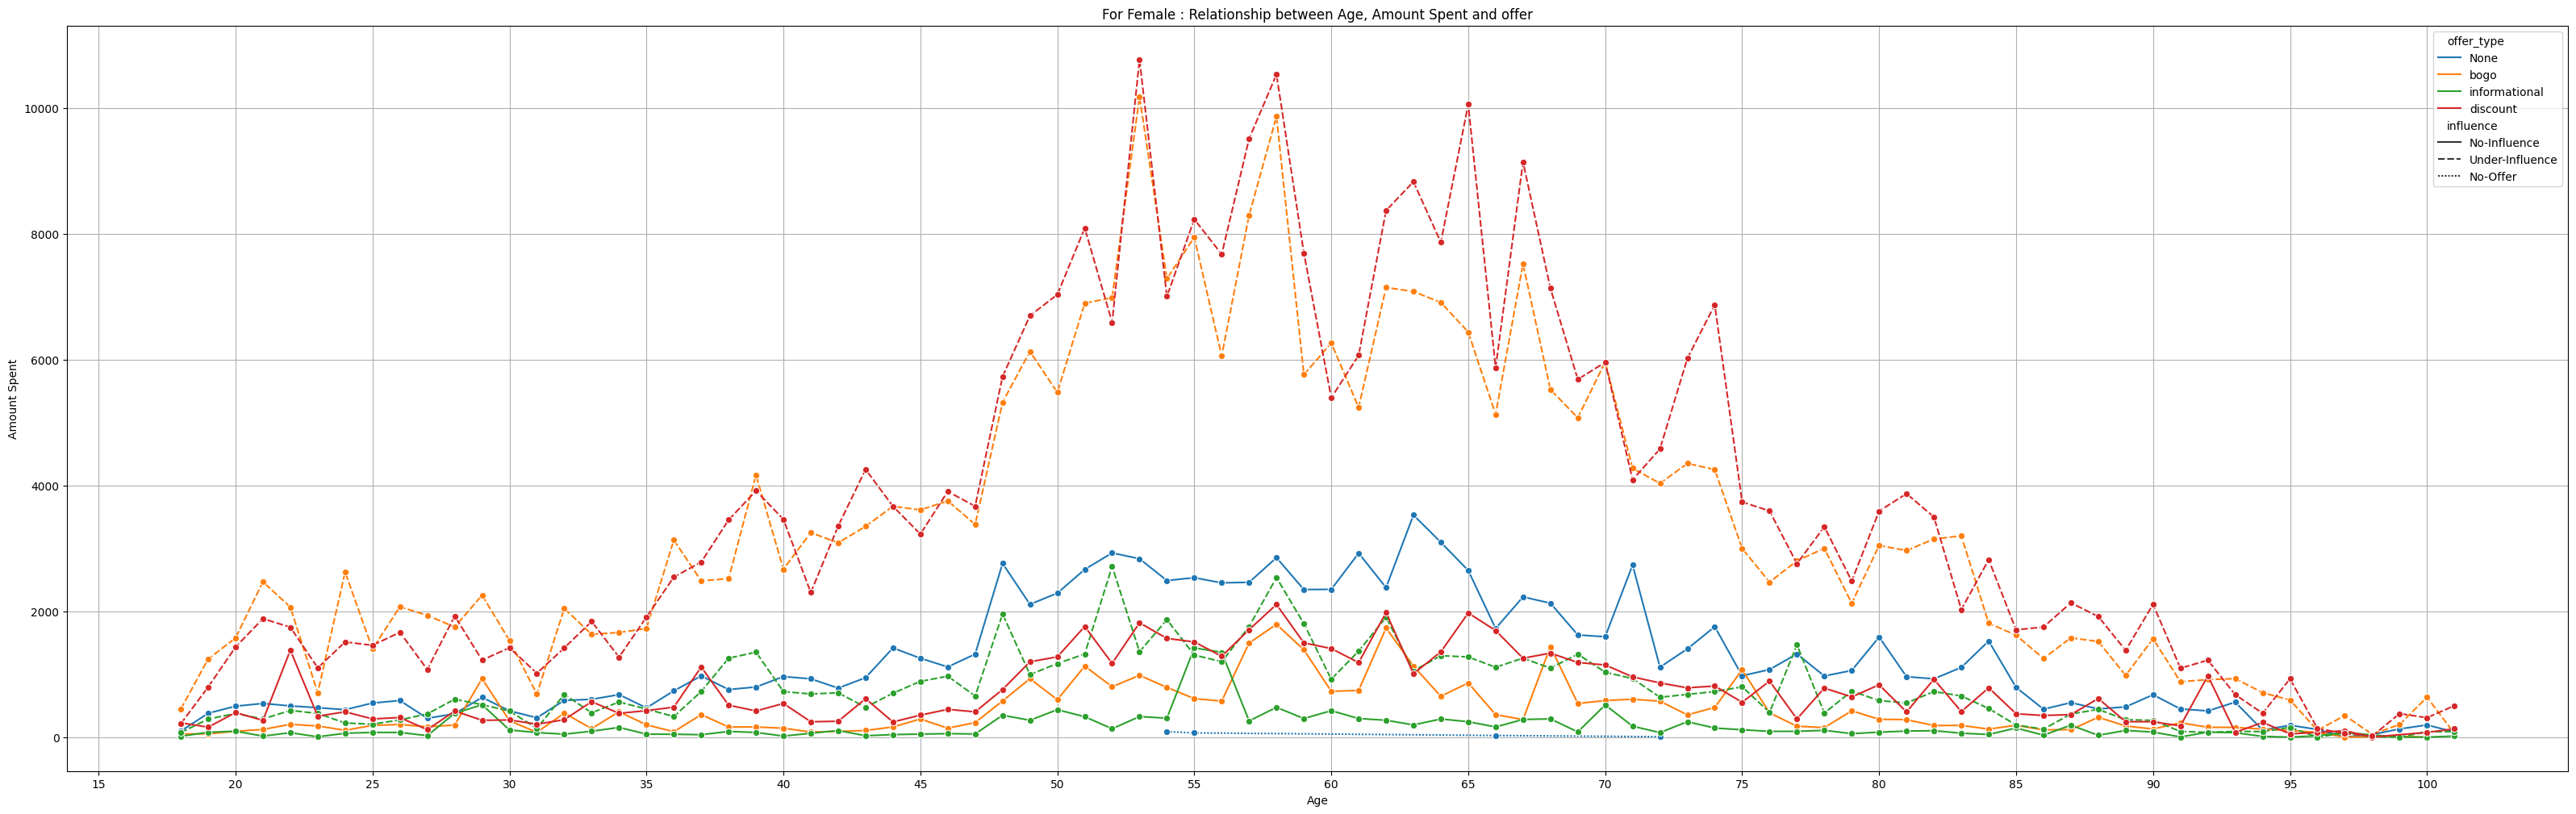

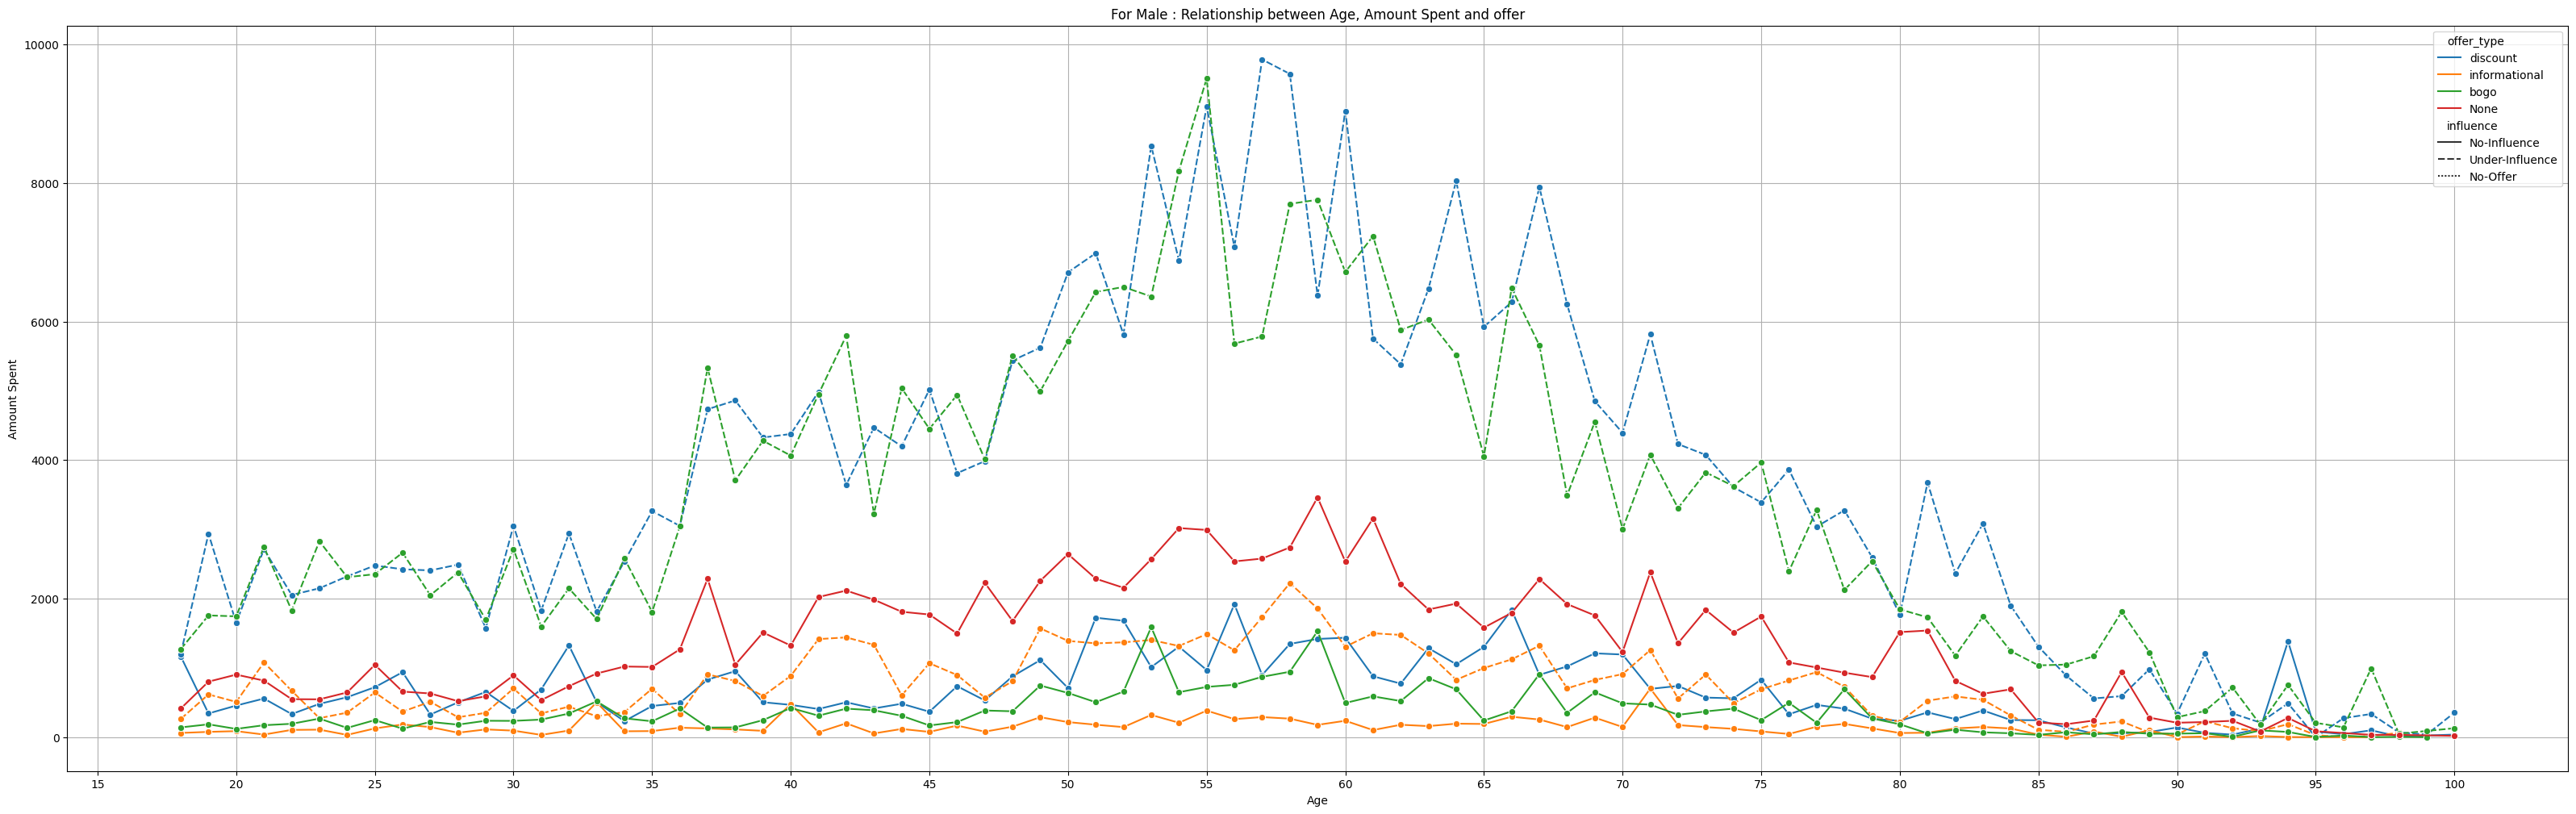

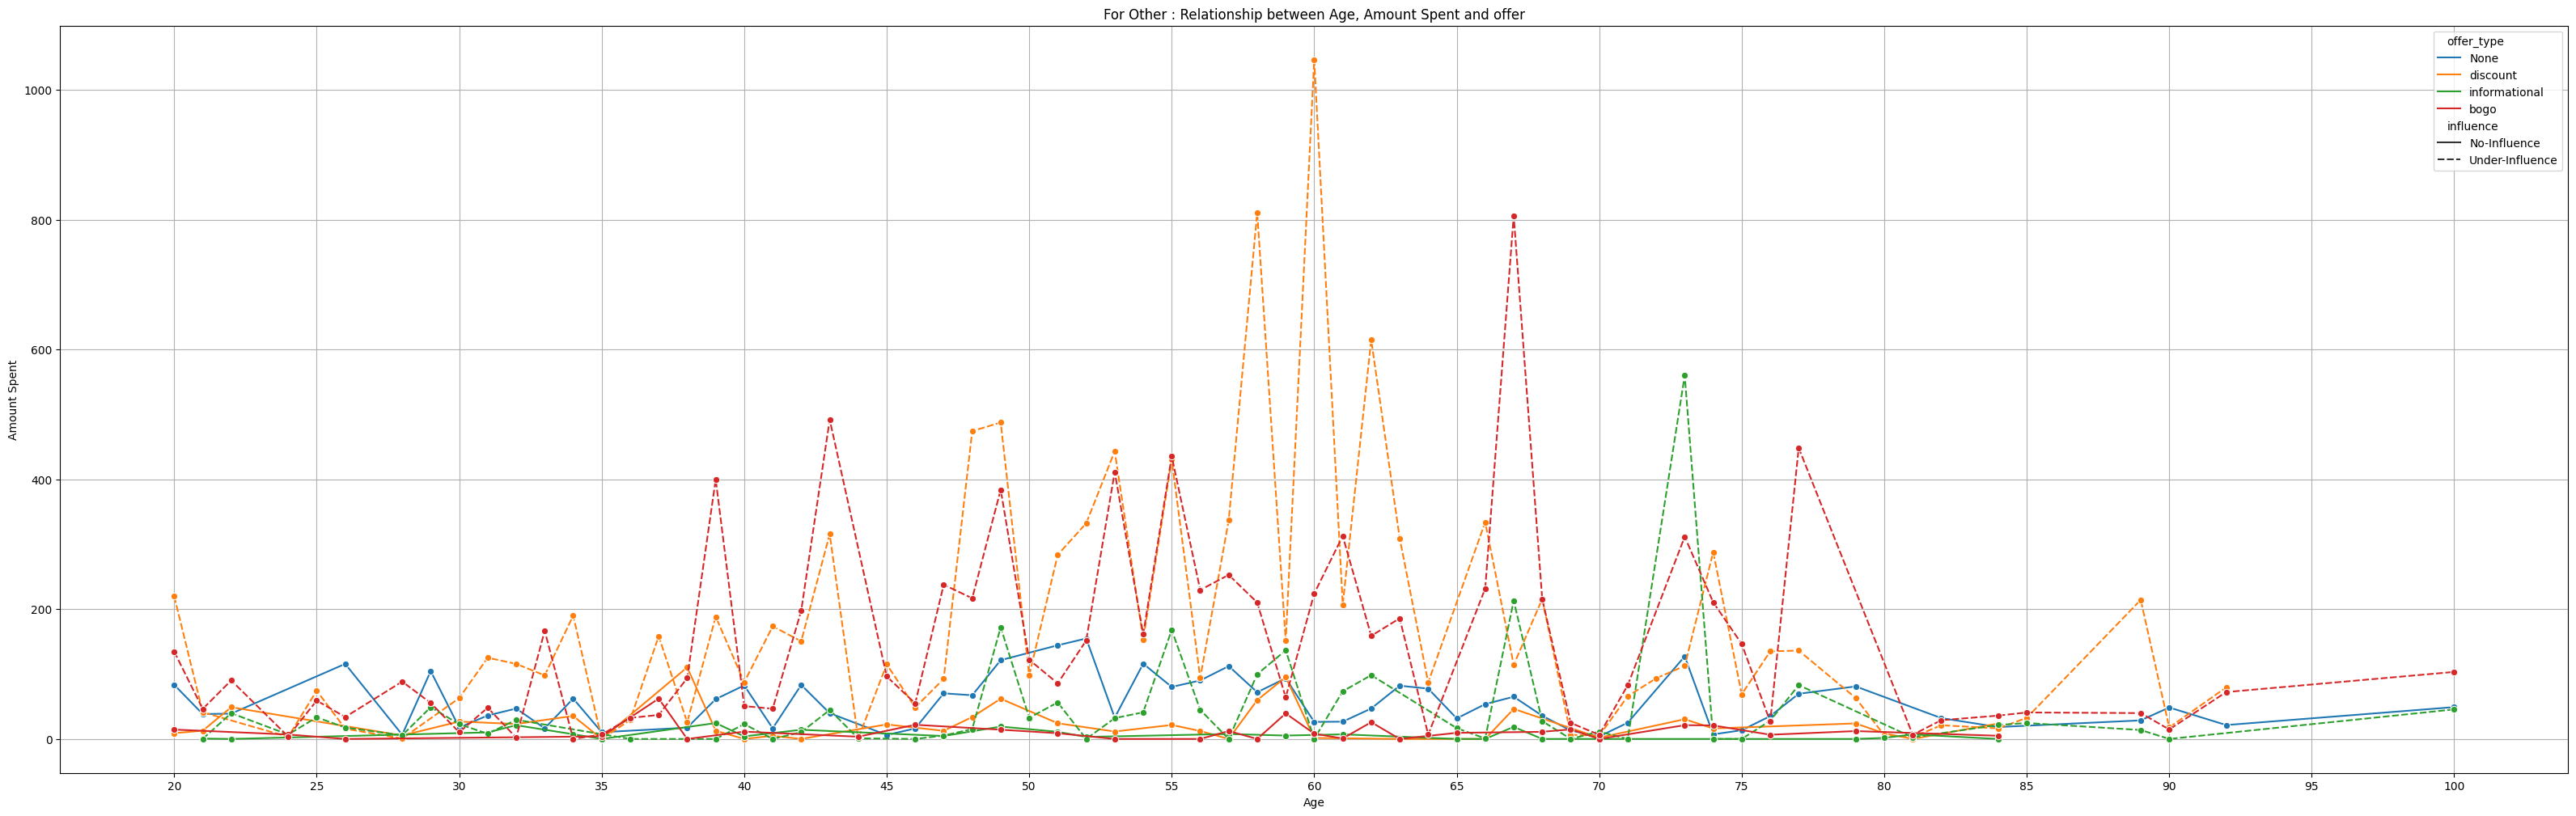

In [90]:
for g in ['F','M','O']:
    if (g == 'F'):
        gender_full = 'Female'
    elif (g == 'M'):
        gender_full = 'Male'
    elif (g == 'O'):
        gender_full = 'Other'

    print("------------------------------------------")
    print("Evaluating the {0} Demography".format(gender_full))
    print("------------------------------------------\n")
    plotGraph(sb2, g, gender_full)
    groupdf(sb2, g, gender_full)



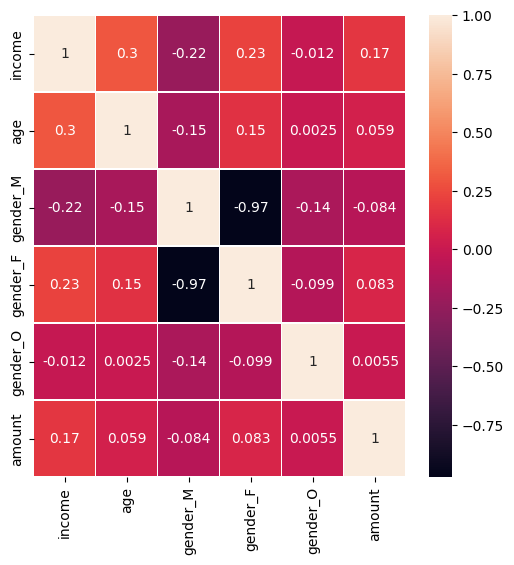

In [91]:
corr = sb2[['income','age','gender_M', 'gender_F', 
                   'gender_O','amount'
                  ]].corr()
# Generate a mask for the upper triangle
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(6,6))
# sns.heatmap(corr, mask=mask, linecolor='white',linewidths=0.1, annot=True)
sns.heatmap(corr,   linecolor='white',linewidths=0.1, annot=True)
# plt.title('Correlation Matrix')
# plt.xlabel('starbucks offers')
# plt.ylabel('starbucks offers')
plt.show()

## Machine Learning


In [92]:
# # from sklearn.metrics import confusion_matrix
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold

# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import BaggingRegressor

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import ExtraTreesClassifier

# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import classification_report

# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler

# # from sklearn.model_selection import train_test_split
# # from sklearn.utils.multiclass import unique_labels

# # from sklearn.model_selection import GridSearchCV
# # from sklearn.pipeline import Pipeline


In [93]:
sb2.columns

Index(['person', 'assigned_offer', 'offer_counter', 'reward', 'amount',
       'reward_amt', 'offer_completed', 'offer_received', 'offer_viewed',
       'transaction', 'or_offer_received', 'time_offer_received_right',
       'person_wo_offer', 'influence', 'person_count', 'offer_result',
       'difficulty', 'duration', 'portfolio_id', 'portfolio_reward', 'web',
       'mobile', 'social', 'email', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'offer_type', 'age', 'became_member_on',
       'profile_id', 'income', 'gender_F', 'gender_M', 'gender_O', 'gender',
       'income_group', 'age_group', 'membership_date', 'membership_year',
       'membership_month', 'membership_day', 'membership_yy_mm'],
      dtype='object')

In [333]:
print("Income Zero = ", sb2[sb2.income == 0]['person'].count())
print("Income Null = ", sb2[sb2.income.isnull()]['person'].count())
print("Membership_yy_mm Zero = ", sb2[sb2.membership_yy_mm == 0]['person'].count())
print("Membership_yy_mm Null = ", sb2[sb2.membership_yy_mm.isnull()]['person'].count())
print("Age Zero = ", sb2[sb2.income == 0]['age'].count())
print("Age Null = ", sb2[sb2.income.isnull()]['age'].count())

print("Income Not Null = ", sb2[sb2.income.notnull()]['person'].count())
cols=['gender_F', 'gender_M',  'gender_O','age','membership_year','income','amount']
xx=sb2[sb2.income != 0][cols]
xx[cols[:-1]]
xx['membership_year']%100




Income Zero =  10922
Income Null =  0
Membership_yy_mm Zero =  10922
Membership_yy_mm Null =  0
Age Zero =  10922
Age Null =  0
Income Not Null =  85708


0        17.0
1        17.0
2        17.0
3        17.0
4        17.0
8        18.0
9        18.0
10       18.0
11       18.0
12       18.0
13       18.0
14       16.0
15       16.0
16       16.0
17       16.0
18       16.0
19       16.0
20       16.0
21       16.0
22       16.0
23       16.0
24       16.0
25       17.0
26       17.0
27       17.0
28       17.0
29       17.0
30       16.0
31       16.0
32       16.0
         ... 
85678    17.0
85679    17.0
85680    17.0
85681    17.0
85682    15.0
85683    15.0
85684    15.0
85685    15.0
85686    15.0
85687    15.0
85688    17.0
85689    17.0
85690    17.0
85691    17.0
85692    17.0
85693    18.0
85694    18.0
85695    18.0
85696    18.0
85697    17.0
85698    17.0
85699    17.0
85700    17.0
85701    17.0
85702    16.0
85703    16.0
85704    16.0
85705    16.0
85706    16.0
85707    16.0
Name: membership_year, Length: 74786, dtype: float64

In [367]:
cols =  ['offer_type_bogo','offer_type_discount', 'offer_type_informational',
             'gender_F', 'gender_M',  'gender_O','age','membership_year','income','amount']
sb2.groupby(['person','offer_type']).sum()

reward        ...         membership_yy_mm
person                           offer_type                   ...                         
0009655768c64bdeb2e877511632db8f bogo           5             ...         201704.0        
                                 discount       4             ...         403408.0        
                                 informational  0             ...         403408.0        
00116118485d4dfda04fdbaba9a87b5c None           0             ...         0.0             
                                 bogo           0             ...         0.0             
0011e0d4e6b944f998e987f904e8c1e5 None           0             ...         201801.0        
                                 bogo           5             ...         201801.0        
                                 discount       8             ...         403602.0        
                                 informational  0             ...         403602.0        
0020c2b971eb4e9188eac86d93036a77 None           0             ...         201603.0        
                                 bogo           10            ...         403206.0        
                                 discount       4             ...         403206.0        
                                 informational  0             ...         201603.0        
0020ccbbb6d84e358d3414a3ff76cffd None           0             ...         201611.0        
                                 bogo           10            ...         403222.0        
                                 discount       3             ...         201611.0        
                                 informational  0             ...         201611.0        
003d66b6608740288d6cc97a6903f4f0 discount       9             ...         605118.0        
                                 informational  0             ...         403412.0        
00426fe3ffde4c6b9cb9ad6d077a13ea None           0             ...         201608.0        
                                 discount       2             ...         806432.0        
                                 informational  0             ...         201608.0        
004b041fbfe44859945daa2c7f79ee64 None           0             ...         201805.0        
                                 bogo           5             ...         201805.0        
                                 discount       2             ...         201805.0        
                                 informational  0             ...         201805.0        
004c5799adbf42868b9cff0396190900 bogo           20            ...         604809.0        
                                 discount       4             ...         403206.0        
005500a7188546ff8a767329a2f7c76a bogo           5             ...         806848.0        
                                 discount       0             ...         201712.0        
...                                            ..             ...              ...        
ffeaa02452ef451082a0361c3ca62ef5 None           0             ...         201702.0        
                                 bogo           10            ...         201702.0        
                                 discount       4             ...         403404.0        
                                 informational  0             ...         403404.0        
ffecb1f8543f4bf7bade023de366d6bf bogo           0             ...         0.0             
                                 discount       0             ...         0.0             
                                 informational  0             ...         0.0             
ffed75d3abc64b488982f50ed12878b5 bogo           0             ...         403606.0        
ffede3b700ac41d6a266fa1ba74b4f16 None           0             ...         0.0             
                                 bogo           0             ...         0.0             
                                 discount       0             ...         0.0             
fff0f0aac6c547b9b263080f09a5586a None       

In [94]:
# # x= sb2['amount'].value_count()
# # x 
# x = sb2[['amount']].copy()
# x['amtint'] = sb2['amount'].astype(int)
# x = x[x['amtint']> 1].groupby('amtint')['amount'].count().reset_index()
# x

In [95]:
# x[x['amount'] == 1] 

In [96]:
# ax = plt.subplot()

# xdf = sb2[['amount']].copy()
# xdf['amtint'] = xdf['amount'].astype(int)
# xdf = xdf[xdf['amtint']> 1].groupby('amtint')['amount'].count().reset_index()


# plt.style.use('default')
# # plt.grid(True, which='both')

# sns.lineplot(x='amtint', y='amount',
#             data = xdf
#             )
# ax.set_xlabel('amount spent')

# plt.title('Amount spent distribution')


In [208]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

### Spending Based on Demography

In [348]:
def loadDataSpends(df):

    df.fillna(0, inplace=True)
#     
    cols =  ['offer_type_bogo','offer_type_discount', 'offer_type_informational',
             'gender_F', 'gender_M',  'gender_O','age','membership_year','income','amount']
    df2 = df[df.income != 0][cols]

    df2['income'] = df2['income']/1000
    df2['membership_year'] = df2['membership_year']%100
         
    
#     df2 = df[['social', 'web', 'mobile', 'email', 
#             'offer_type_bogo','offer_type_discount', 'offer_type_informational',
#             'gender_F', 'gender_M',  'gender_O',
#             'age','membership_year','income']
#           ]
#     df2 = df[['offer_type_bogo','offer_type_discount', 'offer_type_informational',
#             'gender_F', 'gender_M',  
#             'age','membership_year','income']
#           ]

    X = df2[cols[:-1]].values
#     X = df2.values
    labels = cols[:-1]
    y = df2['amount'].values.astype(int)
    
    return X, labels, y

## Regression: Evaluate Regressors

In [349]:
def trainModelSpends2(df):
    X, labels, y = loadDataSpends(df)
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    regression_models = [
                         ['Random Forest Regressor', RandomForestRegressor(), 'fi', 'feature_importances_'],
                         ['KNeighbors Regressor' , KNeighborsRegressor(), 'emp', 'effective_metric_params_'],
                         ['Gradient Boosting Regressor' , GradientBoostingRegressor(), 'fi', 'feature_importances_'],
                         ['Linear Regression' , LinearRegression(), 'coef', 'coef_'],
                         ['ExtraTree Regressor',ExtraTreesRegressor(n_estimators=100, bootstrap=False), 'fi', 'feature_importances_'],
                         ['Bagging Regressor' , BaggingRegressor(), 'ef', 'estimator_features_']
                        ]


# https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation

    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
#     kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
    
    scoring= ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

#     cv = GridSearchCV(estimator=clf, param_grid=parameters, verbose=3, n_jobs=1)
#     print(cv.get_params().keys())

    resultsdf = pd.DataFrame(columns=['regressor','r2-score','mse','rmse','mae','rmae'])
    cvresultsdf = pd.DataFrame()
    allregdf = pd.DataFrame()
    all_reg_feature_imp = pd.DataFrame()

    for vals in regression_models:
        key = vals[0]
        regressor = vals[1]
        feature_coef = vals[2]
        
        print('Processing = {0}'.format(key ))
        print('    cross validating ...')
        cvresult = cross_validate(regressor, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
        
        tempdf = pd.DataFrame(cvresult)
        tempdf['regressor'] = key
        cvresultsdf = cvresultsdf.append(tempdf) # cvresult, ignore_index=True)
    
        print('    fitting model ...')
        reg = regressor.fit(X_train, y_train)
        
#         https://machinelearningmastery.com/calculate-feature-importance-with-python/
        if (feature_coef == 'fi'):
            importance = reg.feature_importances_
        elif (feature_coef == 'emp'):
            importance = 'none' #reg.effective_metric_params_
        elif (feature_coef == 'coef'):
            importance = reg.coef_
        elif (feature_coef == 'ef'):
            importance = 'none'
        else:
            importance = 'none'

        if (importance != 'none'):
            # summarize feature importance
#             print('importance = ', importance)
#             for i,v in enumerate(importance):
#                 print('Feature: {0:0d} - {1} , Score: {2:.5f}'.format(i, labels[i], v))

            # plot feature importance
            plt.title(key + ' : Feature Importance')
            plt.bar([labels[x] for x in range(len(importance))], importance)
            plt.xticks(rotation=90)
            plt.show()
            
            zipped = list(zip(range(len(importance)), labels, importance))
            feature_importance_df = pd.DataFrame(zipped, columns=['feature', 'label', 'importance'])
            feature_importance_df['regressor'] = key
            
            all_reg_feature_imp=all_reg_feature_imp.append(feature_importance_df)

        print('    predicting model ...\n')
        y_predict = reg.predict(X_test )


        score = r2_score(y_test, y_predict)

        mse = mean_squared_error(y_test, y_predict)
        rmse = math.sqrt(mse)  #**(1/2.0)

#         print ('R-Squared = ', score)
#         print("MSE: ", mse)
#         print("RMSE: ", rmse)

        resultsdf = resultsdf.append({'regressor': key,
                                      'r2-score' : score,
                                      'mse'      : mse,
                                      'rmse'     : rmse,
                                      'mae'      : mean_squared_error(y_test, y_predict),
                                      'rmae'     : math.sqrt(mean_squared_error(y_test, y_predict)),
                                     },
                                     ignore_index=True)

#         https://datagy.io/pandas-dataframe-from-list/
        zipped = list(zip(y_train, y_predict))
        regdf = pd.DataFrame(zipped, columns=['y_test', 'y_predict'])
        regdf['regressor'] = key
        
        allregdf = allregdf.append(regdf)
        
        
    print('Done!')
    
    return resultsdf, cvresultsdf, allregdf, all_reg_feature_imp


Processing = Random Forest Regressor
    cross validating ...
    fitting model ...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


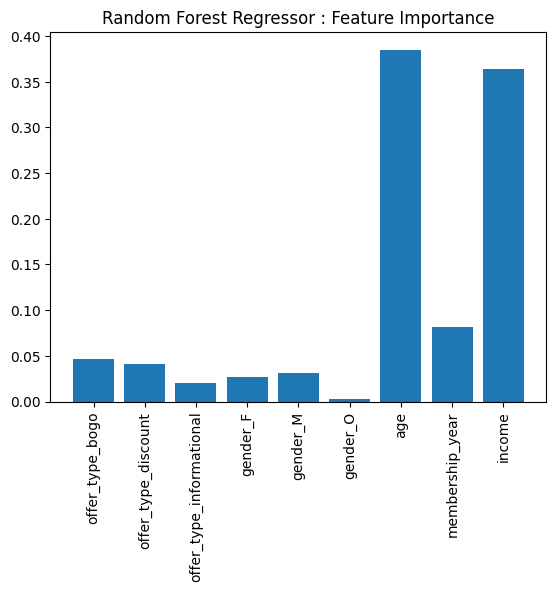

    predicting model ...

Processing = KNeighbors Regressor
    cross validating ...
    fitting model ...
    predicting model ...

Processing = Gradient Boosting Regressor
    cross validating ...
    fitting model ...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


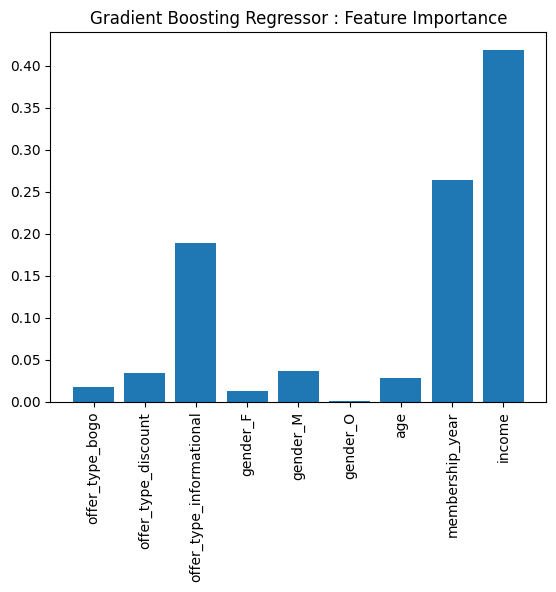

    predicting model ...

Processing = Linear Regression
    cross validating ...
    fitting model ...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


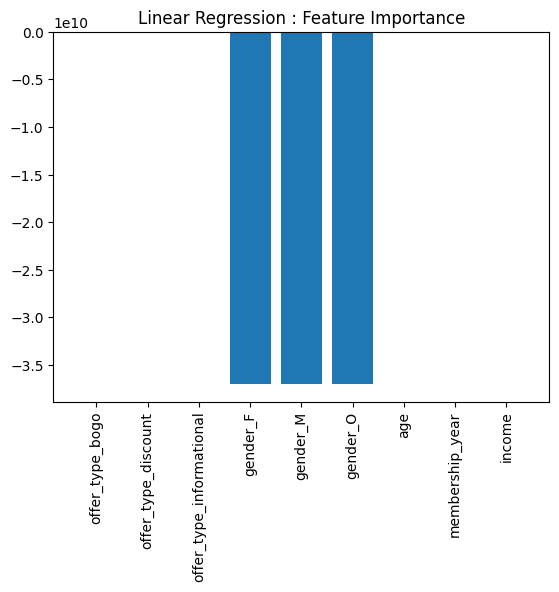

    predicting model ...

Processing = ExtraTree Regressor
    cross validating ...
    fitting model ...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


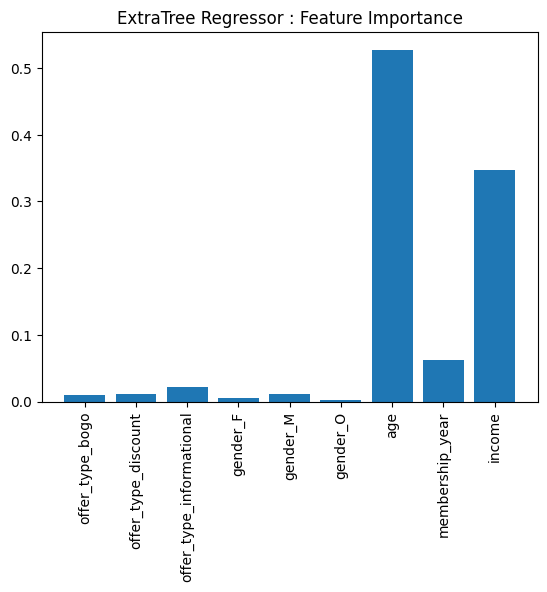

    predicting model ...

Processing = Bagging Regressor
    cross validating ...
    fitting model ...
    predicting model ...

Done!


In [350]:
resultdf, cvresultdf, regdf, impfeatures = trainModelSpends2(sb2)

In [351]:
display(resultdf)
display(cvresultdf)
# display(regdf)

,regressor,r2-score,mse,rmse,mae,rmae
0,Random Forest Regressor,-0.178752,2850.222516,53.387475,2850.222516,53.387475
1,KNeighbors Regressor,-0.089423,2634.225431,51.324706,2634.225431,51.324706
2,Gradient Boosting Regressor,0.069060,2251.012227,47.444834,2251.012227,47.444834
3,Linear Regression,0.053168,2289.441119,47.848105,2289.441119,47.848105
4,ExtraTree Regressor,-0.400210,3385.707291,58.186831,3385.707291,58.186831
5,Bagging Regressor,-0.285059,3107.272518,55.742915,3107.272518,55.742915


,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2,regressor
0,7.763758,0.346864,-21.294628,-11.752686,-2338.257032,-894.922408,-0.210282,0.624445,Random Forest Regressor
1,7.743659,0.350969,-22.321318,-11.550676,-3012.191718,-840.227858,-0.135374,0.618538,Random Forest Regressor
2,7.814819,0.343835,-22.474798,-11.602353,-3237.624775,-821.314195,-0.192304,0.624460,Random Forest Regressor
3,8.445679,0.357522,-21.108062,-11.952872,-2218.229674,-937.152413,-0.308803,0.616254,Random Forest Regressor
4,7.786765,0.343011,-21.778160,-11.711781,-2807.831239,-908.833604,-0.137769,0.595890,Random Forest Regressor
0,1.789121,0.817974,-21.142713,-17.766218,-2163.596160,-1771.517534,-0.119877,0.256581,KNeighbors Regressor
1,1.735812,0.782414,-22.238797,-17.383195,-2855.302178,-1622.859894,-0.076238,0.263225,KNeighbors Regressor
2,1.715308,0.812018,-21.946380,-17.303773,-2894.495331,-1593.860201,-0.065942,0.271220,KNeighbors Regressor
3,1.779858,0.809154,-20.986953,-17.811753,-1989.828298,-1791.404819,-0.174041,0.266454,KNeighbors Regressor
4,1.733490,0.791552,-21.572818,-17.585497,-2637.495423,-1655.905447,-0.068747,0.263706,KNeighbors Regressor


In [352]:
display(cvresultdf.groupby('regressor').mean())

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
regressor,,,,,,,,
Bagging Regressor,0.801716,0.040505,-22.491693,-12.138872,-2893.974256,-969.658513,-0.281238,0.576893
ExtraTree Regressor,5.617649,0.393758,-23.026890,-8.269102,-3286.522705,-725.508726,-0.458270,0.683468
Gradient Boosting Regressor,2.447083,0.019711,-19.344958,-19.245642,-2134.239252,-2107.369629,0.070104,0.080911
KNeighbors Regressor,1.750718,0.802622,-21.577532,-17.570087,-2508.143478,-1687.109579,-0.100969,0.264237
Linear Regression,0.016921,0.002817,-20.083328,-20.082804,-2172.390030,-2171.414606,0.053381,0.052972
Random Forest Regressor,7.910936,0.348440,-21.795393,-11.714074,-2722.826888,-880.490095,-0.196906,0.615917


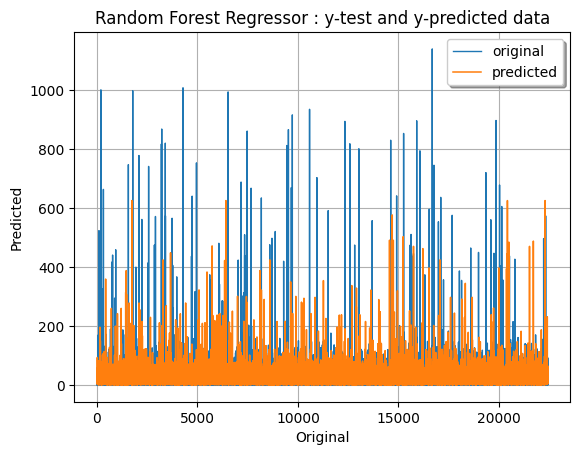

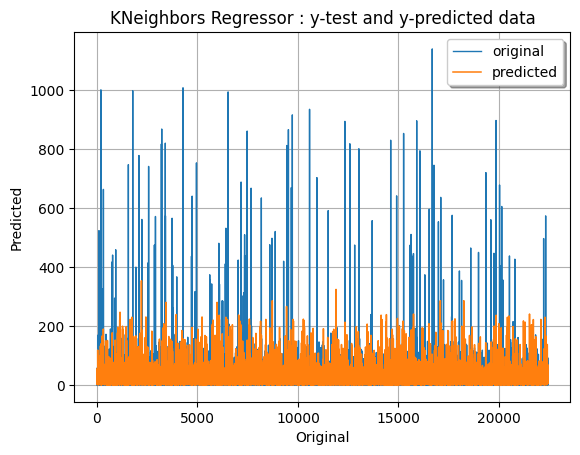

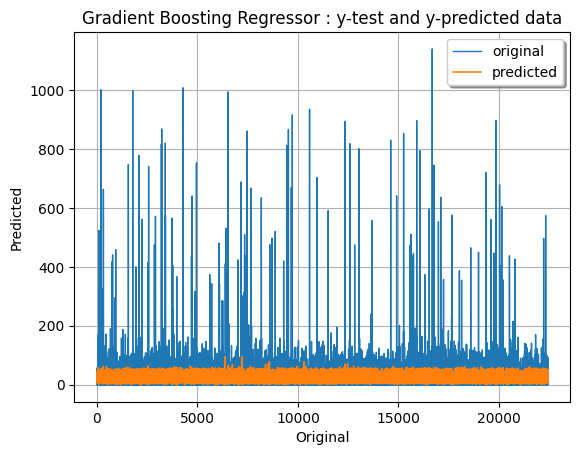

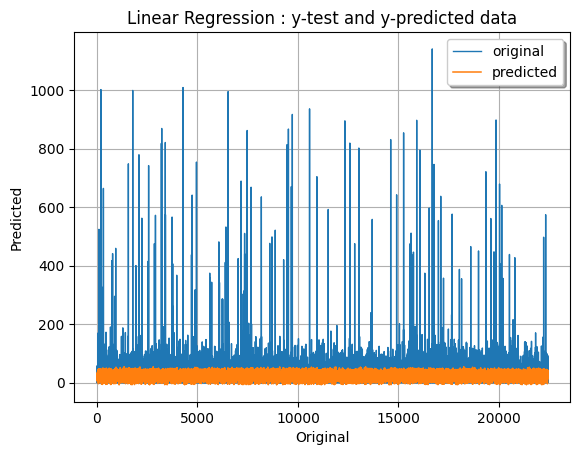

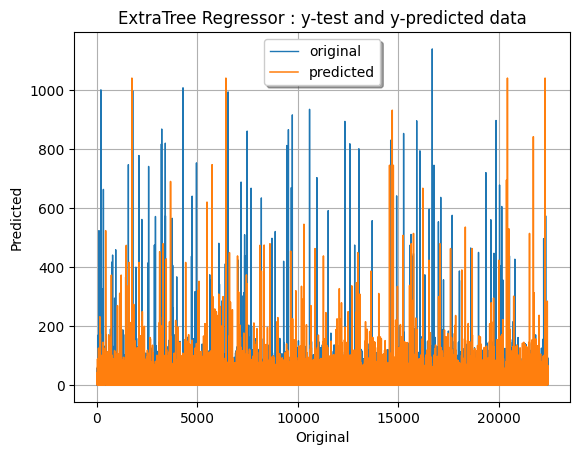

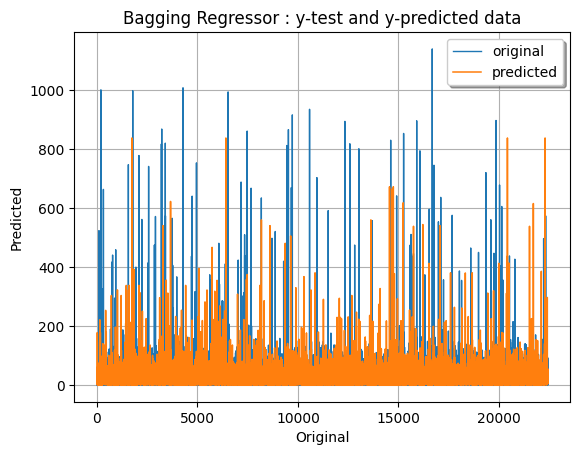

In [353]:
# sns.relplot(x='y_train', hue='y_predict',  col='regressor', kind='line', estimator=sum, ci=None, 
#             data = regdf)

#     https://www.datatechnotes.com/2020/09/regression-example-with-randomforestregressor.html

# regdf = regdf2
x_ax = range(regdf.regressor.value_counts()[0])
regs = regdf.regressor.unique()



for reg in regs:
    y_test = regdf[regdf['regressor'] == reg]['y_test'] 
    y_predict = regdf[regdf['regressor'] == reg]['y_predict'] 

    plt.plot(x_ax, y_test, linewidth=1, label="original")
    plt.plot(x_ax, y_predict, linewidth=1.1, label="predicted")
    
    plt.title(reg + " : y-test and y-predicted data")
    plt.xlabel('Original')
    plt.ylabel('Predicted')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

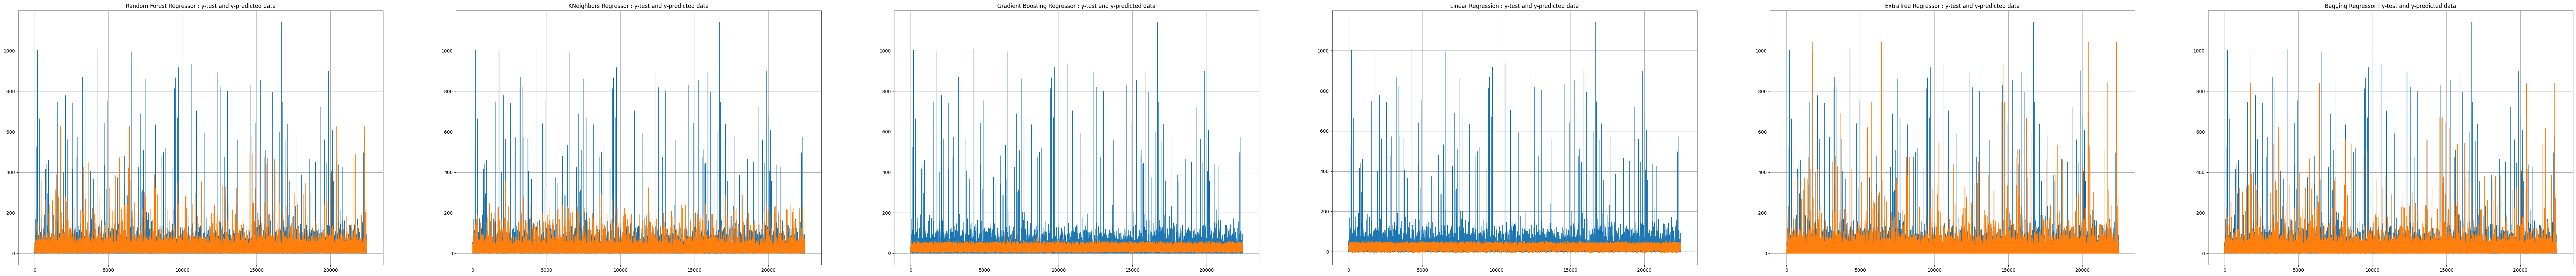

In [354]:
# sns.relplot(x='y_train', hue='y_predict',  col='regressor', kind='line', estimator=sum, ci=None, 
#             data = regdf)

#     https://www.datatechnotes.com/2020/09/regression-example-with-randomforestregressor.html

x_ax = range(regdf.regressor.value_counts()[0])
regs = regdf.regressor.unique()
nplots = len(regs)
i=-1

fig, axes = plt.subplots(nrows=1, ncols=nplots,figsize=(100,10))

for reg in regs:
    i=i+1

    y_test = regdf[regdf['regressor'] == reg]['y_test'] 
    y_predict = regdf[regdf['regressor'] == reg]['y_predict'] 

    axes[i].plot(x_ax, y_test, linewidth=1, label="original")
    axes[i].plot(x_ax, y_predict, linewidth=1.1, label="predicted")
    
    axes[i].set_title(reg + " : y-test and y-predicted data")
    axes[i].grid(True)

plt.show


## Regression: use GridSearchCV to tune hyper-parameters

In [355]:
# ExtraTree regressor has performed better, so lets try to fine tune its hyper parameters
def searchParam(df):
    X, labels, y = loadDataSpends(df)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#     clf = ExtraTreesRegressor()
    clf = RandomForestRegressor()
#     clf = GradientBoostingRegressor()
#     clf = LinearRegression()
    
    scoring= ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

    parameters = {
        'n_estimators': (1, 2, 5, 8, 10,20, 30, 50 ),
        'bootstrap': (True, False),
        'max_depth' : (1, 2, 3, 5) #, 10, 20)
    }
    
#     parameters = {
#         'loss': ('quantile', 'squared_error'),
#         'n_estimators' : (1,5,10),
#         'max_depth' : (5, 10)
#     }

#     parameters = {
#         'fit_intercept' : (True, False),
#         'normalize' : (True, False)
#     }

    cv = GridSearchCV(estimator=clf, param_grid=parameters,    verbose=3, n_jobs=1)
    print(cv.get_params().keys())

    print('fitting model\n')
    cv.fit(X_train, y_train)

    print('predicting model\n')
    y_predict = cv.predict(X_test )

    print('model best param = ', cv.best_params_)
    
    score = r2_score(y_test, y_predict)

    mse = mean_squared_error(y_test, y_predict)
    rmse = mse*(1/2.0)
    print(score, mse, rmse)
    
    return cv

In [356]:
model = searchParam(sb2)  # extraTree

dict_keys(['cv', 'error_score', 'estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])
fitting model

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END bootstrap=True, max_depth=1, n_estimators=1;, score=0.018 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, n_estimators=1;, score=0.026 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, n_estimators=1;, score=0.021 total time=   0.0s
[CV 4/5] END bootst

In [310]:
model.cv_results_

{'mean_fit_time': array([0.00661478, 0.01047292, 0.02476473, 0.03754315, 0.04533739,
        0.08722038, 0.00917635, 0.01362572, 0.03280339, 0.05005221,
        0.0595767 , 0.12004576, 0.0096364 , 0.01650739, 0.03913751,
        0.0611618 , 0.07450557, 0.14790835, 0.01301298, 0.02270603,
        0.05107856, 0.08050308, 0.09806814, 0.19268761, 0.01682363,
        0.03327646, 0.07727017, 0.12075424, 0.1536871 , 0.29511895,
        0.02838507, 0.05282464, 0.13254266, 0.20923343, 0.26252699,
        0.50764837, 0.00570755, 0.00999465, 0.02065916, 0.02903733,
        0.03488894, 0.07042346, 0.00824518, 0.01535234, 0.02966394,
        0.04874363, 0.05943198, 0.11559591, 0.0107307 , 0.01852059,
        0.04041986, 0.0659132 , 0.07902255, 0.16178951, 0.01398282,
        0.02450151, 0.05865173, 0.09417553, 0.12197056, 0.23184762,
        0.02053528, 0.04128742, 0.09890614, 0.1554801 , 0.18915877,
        0.37779369, 0.03494658, 0.06729589, 0.16329455, 0.26877799,
        0.33140364, 0.65032063]

In [311]:

X, labels, y = loadDataSpends(sb2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

y_predict = model.predict(X_test)
score = model.score(X_train, y_train)

mse = mean_squared_error(y_test, y_predict)
rmse = mse*(1/2.0)
print(score, mse, rmse)

array([10,  0, 22, ..., 14, 36, 65])

-0.00035188490530013716 2422.8271617893165 1211.4135808946583


### Regression: Check the score with the best parameters

In [357]:
# ExtraTree regressor has performed better, so lets try to fine tune its hyper parameters
def tryParam(df):
    X, labels, y = loadDataSpends(df)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#     reg = ExtraTreesRegressor(bootstrap=True, max_depth=5, n_estimators=50)
    reg = RandomForestRegressor(bootstrap=True, max_depth=5, n_estimators=50)

    print('fitting model\n')
    reg.fit(X_train, y_train)

    print('predicting model\n')
    y_predict = reg.predict(X_test )

    score = reg.score(X_test, y_test)

    mse = mean_squared_error(y_test, y_predict)
    rmse = mse*(1/2.0)
    print(score, mse, rmse)
    
    return reg

In [358]:
clf=tryParam(sb2)

fitting model

predicting model

0.062152021014459935 2267.7167666960404 1133.8583833480202


## Classification - Evaluate Classifiers

#### responds to an offer

In [104]:
def loadDataResponse(df):

    df.fillna(0, inplace=True)

    X = df[['social', 'web', 'mobile', 'email', 
            'offer_type_bogo','offer_type_discount', 'offer_type_informational',
            'gender_F', 'gender_M', 'gender_O', 
            'age', 'income', 
            'membership_year']
          ].values

    y = df['offer_result'].values
#     y = df['influence'].values
    
#     if (label == 'amount'):
#         y = y.astype(int)
    
    
    return X, y

In [109]:
def loadDataResponse(df):

    df.fillna(0, inplace=True)

    df2 = df[['social', 'web', 'mobile', 'email', 
              'offer_type_bogo','offer_type_discount', 'offer_type_informational',
              'gender_F', 'gender_M', 'gender_O', 
              'age', 'income', 
              'membership_year']
            ]
    X = df2.values
    labels = df2.columns
    y = df['offer_result'].values 

    return X, labels, y

In [110]:
sb2.offer_result.value_counts()

Success    57571
Failure    28137
Name: offer_result, dtype: int64

In [203]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [195]:
def trainModelResponse(df):
    X, labels, y = loadDataResponse(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    classifier_models = [
                         ['Random Forest Classifier', RandomForestClassifier(), 'fi', 'feature_importances_'],
                         ['KNeighbors Classifier' , KNeighborsClassifier(), 'emp', 'effective_metric_params_'],
                         ['ExtraTree Classifier',ExtraTreesClassifier(n_estimators=100, bootstrap=False), 'fi', 'feature_importances_'],
                        ]


    skfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    kfold = KFold(n_splits=5, random_state=42, shuffle=True)
    scoring= ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
#     scoring= ['accuracy', 'f1_samples', 'precision_samples', 'recall_samples']

    resultsdf = pd.DataFrame(columns=['classifier','accuracy','f1','precision','recall'])
    cvresultsdf = pd.DataFrame()
    allclsdf = pd.DataFrame()
    all_cls_feature_imp = pd.DataFrame()

    for vals in classifier_models:
        key = vals[0]
        cls = vals[1]
        feature_coef = vals[2]
        
        print('\nProcessing = {0}'.format(key ))
#         cls = classifier_models[key]
        
        print('    cross validating ...')
        cvresult = cross_validate(cls, X_train, y_train, cv=kfold, scoring=scoring)
        
        tempdf = pd.DataFrame(cvresult)
        tempdf['classifier'] = key
        cvresultsdf = cvresultsdf.append(tempdf) # cvresult, ignore_index=True)
    
        print('    fitting model ...')
        cls.fit(X_train, y_train)

        importance = 'none'

        if (feature_coef == 'fi'):
            importance = cls.feature_importances_
        elif (feature_coef == 'emp'):
            importance = 'none' #reg.effective_metric_params_
        elif (feature_coef == 'coef'):
            importance = cls.coef_
        elif (feature_coef == 'ef'):
            importance = 'none'

        if (importance != 'none'):
            # plot feature importance
#             print('length of importanc = ', len(importance), ' , importance = ', importance)
#             print('labels = ', labels)
            plt.title(key + ' : Feature Importance')
            plt.bar([labels[x] for x in range(len(importance))], importance)
            plt.xticks(rotation=90)
            plt.show()
            
            zipped = list(zip(range(len(importance)), labels, importance))
            feature_importance_df = pd.DataFrame(zipped, columns=['feature', 'label', 'importance'])
            feature_importance_df['classifier'] = key
            
            all_cls_feature_imp=all_cls_feature_imp.append(feature_importance_df)

        print('    predicting model ...\n')
        y_predict = cls.predict(X_test )

        lbls = unique_labels(y_predict)
        confusion_mat = confusion_matrix(y_test, y_predict, labels=lbls)
        accuracy = (y_predict == y_test).mean()
        

        print(classification_report(y_predict, y_test, target_names=lbls))
#         print("Labels:", labels)
        print("Confusion Matrix:\n", confusion_mat)
#         print("Accuracy:", accuracy)

        resultsdf = resultsdf.append({'classifier': key,
                                      'accuracy'  : accuracy_score(y_test, y_predict),
                                      'f1'        : f1_score(y_test, y_predict, average='weighted'),
                                      'precision' : precision_score(y_test, y_predict, average='weighted'),
                                      'recall'    : recall_score(y_test, y_predict, average='weighted'),
                                     },
                                     ignore_index=True)

#         https://datagy.io/pandas-dataframe-from-list/
        zipped = list(zip(y_train, y_predict))
        clsdf = pd.DataFrame(zipped, columns=['y_test', 'y_predict'])
        clsdf['classifier'] = key
        
        allclsdf = allclsdf.append(clsdf)
        
        
    print('Done!')
    
#     return resultsdf,   allclsdf
    return resultsdf, cvresultsdf, allclsdf, all_cls_feature_imp



Processing = Random Forest Classifier
    cross validating ...
    fitting model ...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


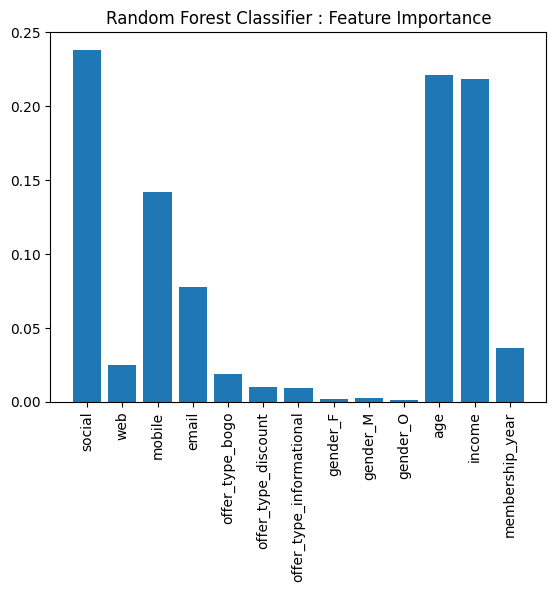

    predicting model ...

              precision    recall  f1-score   support

     Failure       0.68      0.74      0.71      7731
     Success       0.88      0.85      0.87     17982

    accuracy                           0.82     25713
   macro avg       0.78      0.80      0.79     25713
weighted avg       0.82      0.82      0.82     25713

Confusion Matrix:
 [[ 5730  2681]
 [ 2001 15301]]

Processing = KNeighbors Classifier
    cross validating ...
    fitting model ...
    predicting model ...

              precision    recall  f1-score   support

     Failure       0.46      0.75      0.57      5135
     Success       0.92      0.78      0.84     20578

    accuracy                           0.77     25713
   macro avg       0.69      0.76      0.71     25713
weighted avg       0.83      0.77      0.79     25713

Confusion Matrix:
 [[ 3837  4574]
 [ 1298 16004]]

Processing = ExtraTree Classifier
    cross validating ...
    fitting model ...


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


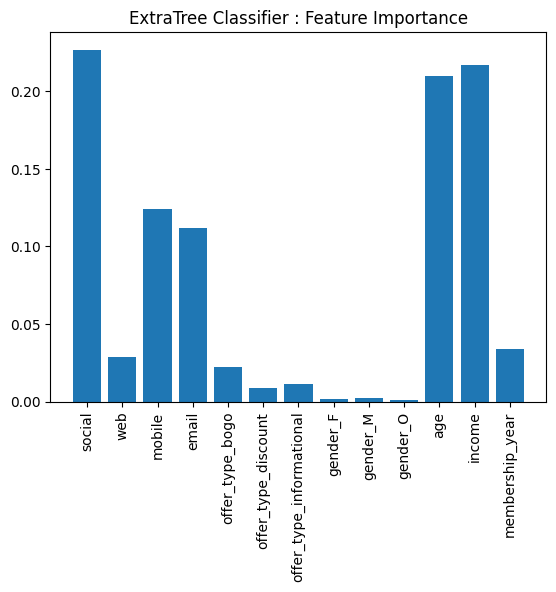

    predicting model ...

              precision    recall  f1-score   support

     Failure       0.68      0.72      0.70      7973
     Success       0.87      0.85      0.86     17740

    accuracy                           0.81     25713
   macro avg       0.78      0.79      0.78     25713
weighted avg       0.81      0.81      0.81     25713

Confusion Matrix:
 [[ 5760  2651]
 [ 2213 15089]]
Done!


In [196]:
resultdf, cvresultdf, clsdf, imp_features = trainModelResponse(sb2)

In [197]:
# Cross Validation resuluts
display(cvresultdf.groupby('classifier').mean())

,fit_time,score_time,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
classifier,,,,,,
ExtraTree Classifier,4.434129,0.760555,0.810084,0.808613,0.807780,0.810084
KNeighbors Classifier,0.280149,1.185724,0.758630,0.741638,0.751308,0.758630
Random Forest Classifier,4.801588,0.690145,0.817551,0.815492,0.814703,0.817551


In [198]:
# Result from Predicting on Test set
resultdf

,classifier,accuracy,f1,precision,recall
0,Random Forest Classifier,0.817913,0.815832,0.815011,0.817913
1,KNeighbors Classifier,0.771633,0.753894,0.767747,0.771633
2,ExtraTree Classifier,0.810835,0.809489,0.808652,0.810835


## Classifier: GridSearchCV to find best hyper Parameters

In [199]:
# ExtraTree Classifier has performed better, so lets try to fine tune its hyper parameters
def clsSearchParam(df):
    X, labels, y = loadDataResponse(df)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    clf = ExtraTreesClassifier()
    
    scoring= ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']

    parameters = {
        'n_estimators': (80,100),
        'bootstrap': (True, False),
        'max_depth' : (15, None)

    }
    cv = GridSearchCV(estimator=clf, param_grid=parameters,    verbose=3, n_jobs=1)
    print(cv.get_params().keys())

    print('fitting model\n')
    cv.fit(X_train, y_train)

    print('predicting model\n')
    y_predict = cv.predict(X_test )

    print('model best param = ', cv.best_params_)

#     lbls = unique_labels(y_predict)
#     confusion_mat = confusion_matrix(y_test, y_predict, labels=lbls)
#     accuracy = (y_predict == y_test).mean()

#     score = cv.score(X_train, y_train)

    return cv

In [200]:
model = clsSearchParam(sb2)

dict_keys(['cv', 'error_score', 'estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])
fitting model

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END bootstrap=True, max_depth=15, n_estimators=80;, score=0.827 total time=   2.2s
[CV 2/5] END bootstrap=True, max_depth=15, n_estimators=80;, score=0.836 total time=   2.2s
[CV 3/5] END bootstrap=True, max_depth=15, n_estimators=80;, score=0.830 total t

In [204]:
# ExtraTree regressor has performed better, so lets try to fine tune its hyper parameters
def tryParamResponse(df):
    X, labels, y = loadDataResponse(df)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    clf = ExtraTreesClassifier(bootstrap=True, max_depth=15, n_estimators=100)

    print('fitting model\n')
    clf.fit(X_train, y_train)

    print('predicting model\n')
    y_predict = clf.predict(X_test )

    score = clf.score(X_train, y_train)

    lbls = unique_labels(y_predict)
    confusion_mat = confusion_matrix(y_test, y_predict, labels=lbls)
#     accuracy = (y_predict == y_test).mean()
    accuracy = accuracy_score(y_test, y_predict)

#     score = clf.score(X_train, y_train)
    print(classification_report(y_predict, y_test, target_names=lbls))
    print("Confusion Matrix:\n", confusion_mat)
    print("accuracy:\n", accuracy)
    print("score:\n", score)



    return clf

classifer = tryParamResponse(sb2)

fitting model

predicting model

              precision    recall  f1-score   support

     Failure       0.68      0.80      0.73      7178
     Success       0.92      0.85      0.88     18535

    accuracy                           0.84     25713
   macro avg       0.80      0.82      0.81     25713
weighted avg       0.85      0.84      0.84     25713

Confusion Matrix:
 [[ 5711  2700]
 [ 1467 15835]]
accuracy:
 0.8379418970948548
score:
 0.8686390532544379


In [ ]:
# def trainModelResponse(df):
#     X, y = loadDataResponse(df)

# #     scaler = MinMaxScaler()
# #     X = scaler.fit_transform(X)


#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


#     classifier_models = {'Random Forest Classifier': RandomForestClassifier(),
#                          'KNeighbors Classifier' : KNeighborsClassifier(),
#                          'ExtraTrees Classifier':ExtraTreesClassifier(n_estimators=100, bootstrap=False)
#                         }

#     skfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     scoring= ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted']
# #     scoring= ['accuracy', 'f1_samples', 'precision_samples', 'recall_samples']

#     resultsdf = pd.DataFrame(columns=['classifier','accuracy','f1','precision','recall'])
#     cvresultsdf = pd.DataFrame()
#     allclsdf = pd.DataFrame()

#     for key in classifier_models:
#         print('\nProcessing = {0}'.format(key ))
#         cls = classifier_models[key]
        
#         print('    cross validating ...')
#         cvresult = cross_validate(cls, X_train, y_train, cv=skfold, scoring=scoring)
        
#         tempdf = pd.DataFrame(cvresult)
#         tempdf['classifier'] = key
#         cvresultsdf = cvresultsdf.append(tempdf) # cvresult, ignore_index=True)
    
#         print('    fitting model ...')
#         cls.fit(X, y)

#         print('    predicting model ...\n')
#         y_predict = cls.predict(X_test )

#         labels = unique_labels(y_predict)
#         confusion_mat = confusion_matrix(y_test, y_predict, labels=labels)
#         accuracy = (y_predict == y_test).mean()
        

#         print(classification_report(y_predict, y_test, target_names=labels))
# #         print("Labels:", labels)
#         print("Confusion Matrix:\n", confusion_mat)
# #         print("Accuracy:", accuracy)

#         resultsdf = resultsdf.append({'classifier': key,
#                                       'accuracy': accuracy
#                                      },
#                                      ignore_index=True)

# #         https://datagy.io/pandas-dataframe-from-list/
#         zipped = list(zip(y_train, y_predict))
#         clsdf = pd.DataFrame(zipped, columns=['y_test', 'y_predict'])
#         clsdf['classifier'] = key
        
#         allclsdf = allclsdf.append(clsdf)
        
        
#     print('Done!')
    
# #     return resultsdf,   allclsdf
#     return resultsdf, cvresultsdf, allclsdf


In [ ]:
# clf = trainModel(sb2, 'RandomForest','influence')

In [ ]:
# def predict(social, web, mobile, email, offer_type, gender, age, income, membership_year):
    
#     bogo = discount = informational = 0
#     male = female = other = 0

#     if offer_type.lower() == 'bogo':
#         bogo = 1
#     elif offer_type.lower() == 'discount':
#         discount = 1
#     else:
#         informational = 1
        
#     if gender.lower() == 'm':
#         male = 1
#     elif gender.lower() == 'f':
#         female = 1
#     else:
#         other = 1

    
#     input_features = [[social,web,mobile,email,
#                        bogo, discount, informational, female, male , other ,age,income,membership_year]]


#     return clf.predict(input_features)

In [ ]:
# offer_type = 'discount'
# social = 0
# web=1
# mobile=1
# email=1
# age = 33
# income = 70000
# gender = 'M'
# membership_yy_mm =2020


# print( "expected spent = $", predict(social, web, mobile, email, offer_type, gender, age, income, membership_yy_mm)[0])

In [ ]:
# offer_type = 'discount'
# social = 0
# web=1
# mobile=1
# email=1
# age = 55
# income = 70000
# gender = 'F'
# membership_yy_mm =2010


# print( "expected spent = $", predict(social, web, mobile, email, offer_type, gender, age, income, membership_yy_mm)[0])

# End of Notebook. Below are just some earlier attempts in preparing data

In [98]:
# def trainModelSpends(df):
#     X, y = loadDataSpends(df)

# #     scaler = MinMaxScaler()
# #     X = scaler.fit_transform(X)


#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


#     regression_models = {'Random Forest Regressor': RandomForestRegressor(),
#                          'KNeighbors Regressor' : KNeighborsRegressor(),
#                          'Gradient Boosting Regressor' : GradientBoostingRegressor(),
#                          'Linear Regression' : LinearRegression(),
#                          'ExtraTree Regressor':ExtraTreesRegressor(n_estimators=100, bootstrap=False),
#                          'Bagging Regressor' : BaggingRegressor()
#                         }
    

# # https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation

#     kfold = KFold(n_splits=5, random_state=42, shuffle=True)
# #     kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
    
#     scoring= ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

# #     cv = GridSearchCV(estimator=clf, param_grid=parameters, verbose=3, n_jobs=1)
# #     print(cv.get_params().keys())

#     resultsdf = pd.DataFrame(columns=['regressor','r2-score','mse','rmse'])
#     cvresultsdf = pd.DataFrame()
#     allregdf = pd.DataFrame()

#     for key in regression_models:
#         print('Processing = {0}'.format(key ))
#         regressor = regression_models[key]
        
#         print('    cross validating ...')
#         cvresult = cross_validate(regressor, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
        
#         tempdf = pd.DataFrame(cvresult)
#         tempdf['regressor'] = key
#         cvresultsdf = cvresultsdf.append(tempdf) # cvresult, ignore_index=True)
    
#         print('    fitting model ...')
#         regressor.fit(X, y)

#         print('    predicting model ...\n')
#         y_predict = regressor.predict(X_test )


#         score = regressor.score(X_train, y_train)

#         mse = mean_squared_error(y_test, y_predict)
#         rmse = mse*(1/2.0)

# #         print ('R-Squared = ', score)
# #         print("MSE: ", mse)
# #         print("RMSE: ", rmse)

#         resultsdf = resultsdf.append({'regressor': key,
#                                       'r2-score': score,
#                                       'mse' : mse,
#                                       'rmse' : rmse},
#                                      ignore_index=True)

# #         https://datagy.io/pandas-dataframe-from-list/
#         zipped = list(zip(y_train, y_predict))
#         regdf = pd.DataFrame(zipped, columns=['y_test', 'y_predict'])
#         regdf['regressor'] = key
        
#         allregdf = allregdf.append(regdf)
        
        
#     print('Done!')
    
#     return resultsdf, cvresultsdf, allregdf


In [ ]:
# def trainModel(df, model, label):
#     X, y = loadData(df, label)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
#     if (model.lower() == 'randomforest'):
#         clf = RandomForestClassifier()
#     else:
#         clf = RandomForestClassifier()

#     parameters = {
#         'n_estimators': (50,100),
#         'bootstrap': (True, False)
#     }
#     cv = GridSearchCV(estimator=clf, param_grid=parameters, verbose=3, n_jobs=1)
# #     print(cv.get_params().keys())

#     print('fitting model\n')
#     cv.fit(X, y)
    
#     print('predicting model\n')
#     y_predict = cv.predict(X_test )
    
#     print('model best param = ', cv.best_params_)

#     print('confusion matrix\n')
#     labels = unique_labels(y_predict)
#     confusion_mat = confusion_matrix(y_test, y_predict, labels=labels)
#     accuracy = (y_predict == y_test).mean()

#     print("Labels:", labels)
#     print("Confusion Matrix:\n", confusion_mat)
#     print("Accuracy:", accuracy)

#     return cv
# #     return model

In [ ]:
# def assignOfferToTransaction(df, portfoliodf):
#     '''
#     The transaction record in the transaction dataset (starbucksdf), do not have offer assigned to it.
#     In order to determine if the offer had influence on the transaction, we need to associate transaction against
#     the offer that is in effect at that moment.
    
#     Parameters:
#     dataframe (df) : dataframe where transactions don't have an association to the offer
#     dataframe (portfoliodf) : dataframe with the offer details
    
#     Return:
#     dataframe : dataframe where offer is now associated with the transaction
#     '''
    
#     '''
#     1. ofr_rcvd -> df with all offer_received
#     2. df2 -> copy of the passed df
#     3. df2 -> merge with ofr_rcvd on person. this increases each person data by number of offer received
#     4. for offer-received, offer-viewed and offer-complete, since they all have offer-id, keep only those offer-recived
#         where the offer-received offer and offer for these matches
#     5. for Transactions, check which ones time falls within the 
#     '''
    
#     # breakup the dataframe into two, one containing only offer-received and second that don't have offer-received
#     # filter out all transactions for offer received
#     ofr_rcvd = df[df['event_offer received'] == 1][
#             ['person','time','offer','difficulty','duration','offer_duration_hrs','offer_validity_hrs']
#         ].reset_index()
    
#     ofr_rcvd.rename(columns={'person'  : 'or_person', 
#                              'time'    : 'or_time', 
#                              'offer'   : 'or_offer',
#                              'difficulty': 'or_difficulty',
#                              'duration': 'or_duration',
#                              'offer_duration_hrs' : 'or_offer_duration_hrs',
#                              'offer_validity_hrs' : 'or_offer_validity_hrs'
#                             }, 
#                     inplace=True)
   
    
#     # merge will result in joining each row in the dataset with the dataset of offer-received
#     # this allow us to match the offer received with the other events
#     # think of it is like a left outer join in SQL
    
#     df2 = df[['person','time','amount','reward','offer','event2',
#              'event_offer received','event_offer viewed','event_offer completed','event_transaction']].copy().reset_index()
    
#     df2 = df2.merge(ofr_rcvd, 
#                     how='left', left_on=['person'], right_on=['or_person' ])
    

#     # to simulate the SQL where clause here, we first determine the rows for which time falls within the offer validity period
#     conditions = [(
#                     (df2['offer'] == df2['or_offer']) & 
#                     (df2['event_transaction'] == 0)   &
#                     (df2['time'].between(df2['or_time'], df2['or_offer_validity_hrs'], inclusive='both') ) 
#                     ),
#                   (
#                     (df2['time'].between(df2['or_time'], df2['or_offer_validity_hrs'], inclusive='both') ) &
#                     (df2['event_transaction'] == 1))
#                  ]
#     choices    = [df2['or_offer'],df2['or_offer']  ]

#     df2['nor_offer'] = np.select(conditions, choices, default='')
#     df2['keep']      = np.select(conditions, [1, 1],  default='')


#     # SQL Where clause: the Transactions don't have offer associated to them, 
#     # in addition, we have transactions that are not influenced by the offer, i.e., occurred outside of offer validity hrs
#     # so we eliminate all non-transaction rows where the new_offer is blank
#     # in other words, we choose where either its a transaction row or we have a new-offer
#     df2 = df2[(df2['event_transaction'] == 1) | (df2['nor_offer'] != "")]
    
    
#      # drop the duplicates, this eliminates the duplicates

#     df2.drop_duplicates(subset=['index_x', 'nor_offer','keep'], keep='first', inplace=True)
# #     df2.sort_values(by=['index_x', 'keep'], inplace=True)
# #     df2.drop_duplicates(subset=['index_x' ], keep='last', inplace=True)

# #     for i in range(3):
#         # person where transactions are matched with multiple offers, including no-offer.
#     dup_trans = df2[(df2['event_transaction'] == 1)].groupby(['person','time','event2'])['event_offer received'].count().reset_index()

#     dup_trans = dup_trans[dup_trans['event_offer received'] > 1]

#     df2 = df2.merge(dup_trans, how='left', left_on=['person','time', 'event2'], 
#                                           right_on=['person','time', 'event2'])

# #         print("i = ", i, "\n", df2.columns)


#         #         print(df2[df2['person'] == '0009655768c64bdeb2e877511632db8f'][['nor_offer','event2_y']] )
        
# #     df2.drop(
# #         df2[(df2['event_transaction'] == 1) & 
# #             (df2['event_offer received_y'] > 1) &
# #             (df2['nor_offer'] == '')
# #            ].index,
# #         inplace=True
# #     )

#     df2['offer2'] = df2[df2['event_offer completed'] == 1]['nor_offer']
#     df2['offer2'].fillna(method='bfill', inplace=True)
    
# #     df2.drop(
# #         df2[(df2['event_offer received_y'] > 1) &
# #             (df2['offer2'] != df2['nor_offer'])
# #            ].index,
# #         inplace=True
# #     )

# #     df2['offer2'] = df2[df2['event_offer completed'] == 1]['nor_offer']
# #     df2['offer2'].fillna(method='ffill', inplace=True)

    
#     conditions = [df2['nor_offer'] == '']
#     choices = [df2['offer2']]
#     df2['nor_offer'] = np.select(conditions, choices, default=df2['nor_offer'])

    
# #     df2 = df2.merge(ofr_rcvd, 
# #                 how='left', left_on=['person'], right_on=['or_person' ])

#     df2['offer2'].fillna(method='ffill', inplace=True)
#     df2['nor_offer'].fillna(method='ffill', inplace=True)

#     df2.drop(
#         df2[(df2['event_offer received_y'] > 1) &
#             (df2['offer2'] != df2['nor_offer']) 
#            ].index,
#         inplace=True
#     )
    
# #         if (i <= 1):
# #             df2.drop(columns=['event_offer received_y'], inplace=True)
# #             df2.rename(columns={'event_offer received_x':'event_offer received'}, inplace=True)

#     # where transaction are duplicated with informational and non-informational offer, we prioritize non-informational
# #     df2.drop(
# #         df2[(df2['event_transaction'] == 1) & 
# #             (df2['event_offer received_y'] > 1) &
# #             (df2['or_difficulty'] == 0)
# #            ].index,
# #         inplace=True
# #     )

# #     conditions = [(
# #                     (df2['event_transaction'] != 1)
# #                  )]
# #     choices    = [np.nan] 

# #     df2['event2_y'] = np.select(conditions, choices, default=df2['event2_y'] )

            
# #     https://stackoverflow.com/questions/11976503/how-to-keep-index-when-using-pandas-merge
#     df3 = df[['person','time','amount','reward',
#               'offer','event2','event_offer received',
#               'event_offer viewed','event_offer completed',
#               'event_transaction']].merge(df2[['time','or_time','offer2',
#                                                'index_x','nor_offer','keep','event_offer received_y',
#                                                'or_difficulty',
#                                                'or_offer_duration_hrs',
#                                                'or_offer_validity_hrs']] 
#                                         , how='left', left_on=df.index, right_on=df2['index_x']) #.set_index(df.index)
    
#     # CLEANUP
#     df3.rename(columns={'nor_offer': 'associated_offer',
#                         'event2'   : 'event',
#                         'event_offer received' : 'offer_received',
#                         'event_offer viewed'   : 'offer_viewed',
#                         'event_offer completed': 'offer_completed',
#                         'event_transaction'    : 'transaction',
#                         'or_offer_duration_hrs': 'offer_duration_hrs',
#                         'or_offer_validity_hrs': 'offer_validity_hrs'
#                        }, inplace=True)
    


#     conditions = [(
#                     (df3['transaction'] == 0) &
#                     (df3['time_x'].between(df3['or_time'], df3['offer_validity_hrs'], inclusive='both'))     )
#                  ]
#     choices    = [ 1] 

#     df3['keep2']      = np.select(conditions, choices,  default='')
    
# #     df3.drop(
# #         df3[(df3['event_offer received_y'] > 1) &
# #             (df3['keep'] != 1) 
# #            ].index,
# #         inplace=True
# #     )    


# #     df3 = df3.merge(portfoliodf, how='left', left_on='associated_offer', right_on='portfolio_id' ).set_index(df3.index)
# #     df3.drop(columns=['key_0','index_x','keep', 'portfolio_id'], inplace=True)

    
    
#     return df3, dup_trans



# #     # filter out all transaction what are othere then the offer-received
# #     non_ofr_rcvd = df[df['event_offer received'] != 1][['person','event2','time','offer']].reset_index()
# #     non_ofr_rcvd.rename(columns={'person': 'nor_person', 
# #                                  'time' : 'nor_time', 
# #                                  'offer':'nor_offer' }, inplace=True)


# #     # we combine the two as  a left outer join, so that offer-received are in the same row as non-offer-received data
# #     df2=non_ofr_rcvd.merge(ofr_rcvd, how='left', left_on=['nor_person'], right_on=['or_person' ])




    
    
    
# #     conditions = [
# #         (df2['time'].between(df2['or_time'],
# #                             df2['or_offer_validity_hrs'], inclusive='both') ) &
# #         (df2['event_transaction'] == 1)
# #     ]

# #     choices = [df2['or_offer'] ]

# #     df2['nor_offer'] = np.select(conditions, choices, default='')
# #     df2['keep'] = np.select(conditions, [1], default='')

# #     conditions = [df2['or_offer'].isnull()]

# #     choices = [df2['nor_offer']]

# #     df2['offer2'] = np.select(conditions, choices, default=df2['or_offer'])    
    
    
# #     df2.drop_duplicates(subset=['index_x'], keep='first', inplace=True)
      
# #     df2 = df.merge(df2,
# #                    how='left', 
# #                    left_on=df.index, 
# #                    right_on=df2['index_x'], 
# #                    suffixes=('', "_right")
# #                   )

# #     conditions = [df2['or_offer'].isnull()]

# #     choices = [df2['nor_offer']]

# #     df2['offer2'] = np.select(conditions, choices, default=df2['or_offer'])    

# # #     print(df2.columns)
# #     df2.drop(columns = ['index_x', 'nor_person',
# #                         'event2_right', 'nor_time', 'nor_offer', 'index_y', 'or_person',
# #                         'or_time', 'or_offer', 'or_duration', 'offer_duration_hrs_right',
# #                         'offer_validity_hrs_right',
# #     ])
    


In [ ]:
# sb2

In [ ]:
# sb2[['difficulty', 'duration', 
#             'social', 'web', 'mobile', 'email', 
#             'offer_type_bogo','offer_type_discount', 'offer_type_informational',
#             'age', 'income', 
#             'gender_F', 'gender_M', 'gender_O', 
#             'membership_yy_mm']
#           ]

In [ ]:
# sb2[sb2['offer_type'].isnull()]

In [ ]:
# profile2.columns

In [ ]:
# sb2[sb2['influence'] =='No-Influence']

In [ ]:
# rdf.columns

In [ ]:
# # sb1['offer2'] = sb1[sb1['offer_completed'] == 1]['associated_offer']
# udf[['offer_received_x','offer_viewed','offer_completed','transaction']].sum()
# # udf2.columns



In [ ]:
# sb1['offer2'] = sb1[sb1['offer_completed'] == 1]['associated_offer']
# rdf[['offer_received','offer_viewed','offer_completed','transaction']].sum()
# udf2.columns

In [ ]:
# trans_portfolio_df[['event_offer received','event_offer viewed','event_offer completed','event_transaction']].sum()

In [ ]:
# udf2.columns
# # udf2[udf2['during_offer_validity'] == False]

In [ ]:
# trans_portfolio_df.columns

In [ ]:
# x=trans_portfolio_df.merge(udf2, how='left', left_on=trans_portfolio_df.index, right_on=udf2.index_x)

In [ ]:
# x[(x['event_offer viewed'] == 1) &  (x['index_x'].isnull())]

In [ ]:
# dup

In [ ]:
# sb1['offer2'].fillna(method='bfill', inplace=True)
# sb1[(sb1['person'] == '0020c2b971eb4e9188eac86d93036a77') & (sb1['time'] == 510) ]

In [ ]:
# trans_portfolio_df[trans_portfolio_df['person'] == '0020c2b971eb4e9188eac86d93036a77']
# rdf[(rdf['person'] == '54890f68699049c2a04d415abc25e717')  ]

# rdf.groupby('influence')['influence'].count()

In [ ]:
# trans_portfolio_df[trans_portfolio_df.index == 12659]

In [ ]:
# conditions = [(sb1['event_offer received_y'] > 1) & (sb1['offer2'] != sb1['associated_offer'])]
# choices = [1]
# sb1['remove'] = np.select(conditions, choices, default='' ) 
# sb1[(sb1['person'] == '0020ccbbb6d84e358d3414a3ff76cffd') ]

In [ ]:
# sb1[(sb1['person'] == '0020ccbbb6d84e358d3414a3ff76cffd') & (sb1['matched_offer'] == True)]

In [ ]:
# sb1[(sb1['person'] == '0020ccbbb6d84e358d3414a3ff76cffd') &
#     (sb1['event_offer received_y'] > 1) &
#     (sb1['keep'] != 1) 
#    ]

In [ ]:
# print(trans_portfolio_df.shape, sb1.shape, dt.shape)

In [ ]:
# sb1['cumsum'] = sb1[sb1['event_offer received_y'] > 1].groupby(['person','associated_offer'])['amount'].cumsum()

In [ ]:
# sb1[(sb1['event_offer received_y'] > 1) & (sb1['person'] == '0009655768c64bdeb2e877511632db8f')]

In [ ]:
# sb1[(sb1['transaction'] == 1) & 
#     (sb1['event2_y'] > 1) &
#     (sb1['or_difficulty'] == 0)
#    ]

In [ ]:
# # starbucksdf[starbucksdf.index.isin(set(starbucksdf.index).difference(set(sb1['index_x'])))]
# # portfolio2.columns
# x=sb1[sb1['event2_y'] > 1].groupby(['person','associated_offer','or_difficulty','time_x'])['amount'].sum().unstack().reset_index()
# x.fillna(0, inplace=True)
# x


In [ ]:
# sb1[(sb1['event2_y'] > 1) & (sb1['or_difficulty'] == 0)].count()

In [ ]:
# # sb1.drop_duplicates(subset=['index_x'], keep='first', inplace=True)
# # sb1
# # sb1.columns
# # sb1[sb1.index != sb1['key_0']]
# sb1[(sb1['person'] == '0009655768c64bdeb2e877511632db8f') & (sb1['transaction'] == 1)].groupby(['person','time_x'])['event'].count().reset_index()

# # x=sb1[(sb1['transaction'] == 1)].groupby(['person','time_x'])['event'].count().reset_index()

In [ ]:
print(sb2.shape, trans_portfolio_df.shape)

In [ ]:
udf2.columns

In [ ]:
# # sb1[sb1['person'] == '0020ccbbb6d84e358d3414a3ff76cffd']
# # sb2[sb2['person'] == '0011e0d4e6b944f998e987f904e8c1e5']
# # sb1[sb1['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']
# # sb1[sb1['person'] == 'de90515e9f174ddfb8b4c677448286ef']
# # sb1[sb1['person'] == '00116118485d4dfda04fdbaba9a87b5c']
# # sb1[sb1['person'] == 'ff8bee9ba3754ac687d9af685b2981b7']
# # sb1[sb1['person'] == '00c2f812f4604c8893152a5c6572030e']
# # udf2[udf2['person'] == '0009655768c64bdeb2e877511632db8f']

# def showdata(df, person):
#     display(df[df['person'] == person])
    
# showdata(sb2, '02c083884c7d45b39cc68e1314fec56c')

In [ ]:
# sb1[(sb1['person'] == '0009655768c64bdeb2e877511632db8f') & 
#     (sb1['event2_y'] > 1) & 
#     (sb1['transaction'] == 1)] #.sort_values(['person','associated_offer','time_x'])

In [ ]:
# dt[dt['per'] == '0009655768c64bdeb2e877511632db8f']

In [ ]:
# sb1[(sb1.associated_offer != sb1.offer) & (sb1['transaction'] != 1)  ] 

In [ ]:
# x = udf2.groupby(['person','assigned_offer']).sum()

In [ ]:
# x[(x['offer_completed'] >= 1)  & (x['amount'] == 0)]

In [ ]:
# # create separate columns when the offer has influence and when it has no influence
# # a factor of 10, will help in consolidating when certain row results has multiple values like both influence and no_influence
# # a scenario where offer is viewed after its validity has expired
# ### offer_influence_yes : offer was sent and had an influence on the transactions, if any
# ### offer_influence_no  : offer sent has expired and had NO influence on the transactions, if any
# ### offer_not_sent      : Offer was not sent, so no influence on the transactions, if any

# starbucksdf['offer_influence_yes'] =starbucksdf[
#                                    (starbucksdf['time'].between(starbucksdf['time_offer_received'], 
#                                                                  starbucksdf['offer_validity_hrs']))
#                                   ]['temp_constant']

# starbucksdf['offer_influence_no'] =starbucksdf[~
#                                    (starbucksdf['time'].between(starbucksdf['time_offer_received'], 
#                                                                  starbucksdf['offer_validity_hrs']))
#                                   ]['temp_constant'] * 10


# starbucksdf['offer_not_sent'] = starbucksdf[starbucksdf['person'].isin(person_wo_offer)
#                                            ]['temp_constant'] * 100



# starbucksdf['offer2'] =starbucksdf[(starbucksdf['time'].between(starbucksdf['time_offer_received'],
#                                                                 starbucksdf['offer_validity_hrs']))
#                                   ]['offer']

# # starbucksdf['offer2'] =starbucksdf[~
# #                                    (starbucksdf['time'].between(starbucksdf['time_offer_received'], 
# #                                                                  starbucksdf['offer_validity_hrs']))
# #                                   ]['tempcol']

# # starbucksdf['out-of-validity'] =starbucksdf[~
# #                                             (starbucksdf['time'].between(starbucksdf['time_offer_received'], 
# #                                                                          starbucksdf['offer_validity_hrs']))
# #                                            ]['tempcol']


In [ ]:
# starbucksdf['offer2'] =starbucksdf[(starbucksdf['time'].between(starbucksdf['time_offer_received'], 
#                                                                 starbucksdf['offer_validity_hrs']))]['offer']

In [ ]:
# #  https://stackoverflow.com/questions/43648160/using-fillna-method-on-multiple-columns-of-a-pandas-dataframe-failed

# starbucksdf.fillna(dict.fromkeys(['offer_influence_yes','offer_influence_no','offer_not_sent'],0), inplace=True)
    
# # starbucksdf[['offer_influence_yes','offer_influence_no','offer_not_sent']].fillna(value=0, inplace=True)

In [ ]:
# starbucksdf['influence_yes_no'] = starbucksdf['offer_influence_yes'] + starbucksdf['offer_influence_no']  + starbucksdf['offer_not_sent']

In [ ]:
# # https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-where-method-and-masking


# conditions = [
#     (starbucksdf['offer_not_sent'] == 1000),
#     (starbucksdf['offer_influence_no'] == 100),
#     (starbucksdf['offer_influence_yes'] == 10)
# ]

# # choices = ['No Offer', 'No Influence', 'Offer Influence']
# choices = ['No Offer', 'No Influence', starbucksdf['offer']]


# starbucksdf['offer2'] = np.select(conditions, choices, default='exception')

In [ ]:
# starbucksdf.head()

In [ ]:
# starbucksdf[starbucksdf['person']=='da7a7c0dcfcb41a8acc7864a53cf60fb']

In [ ]:
# starbucksdf[starbucksdf['person']=='fff0f0aac6c547b9b263080f09a5586a']

In [ ]:
# starbucksdf[starbucksdf['offer2'].isnull()] 

In [ ]:
# starbucksdf[~starbucksdf['influence_yes_no'].isin([10,100,1000])]

# starbucksdf[(starbucksdf['offer_influence_yes'] > 0) & (starbucksdf['offer_influence_no'] > 0)]

# tempperson = starbucksdf[starbucksdf['influence_yes_no'] > 1000]['person']
# starbucksdf[starbucksdf['person'].isin(tempperson)]

# starbucksdf['person'].isin([starbucksdf[starbucksdf['influence_yes_no'] > 1000]['person'].values])

In [ ]:
# starbucksdf[starbucksdf['person'] =='12ede229379747bd8d74ccdc20097ca3']

# starbucksdf[starbucksdf['person'] =='0009655768c64bdeb2e877511632db8f']




In [ ]:
# starbucksdf[starbucksdf['offer2'] =='']



In [ ]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!


# starbucksdf['offer2'] = starbucksdf['offer2'].fillna(value="")
# starbucksdf['out-of-validity'] = starbucksdf['offer2'].fillna(value="")

In [ ]:

# starbucksdf[['person','event2','offer','offer2','person_wo_offer']]
# starbucksdf[starbucksdf['offer2'] != ""][['person','event2','offer','offer2','person_wo_offer','out-of-validity']]


In [ ]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# starbucksdf['offer2'] = starbucksdf['offer2'] + starbucksdf['person_wo_offer']

In [ ]:
# starbucksdf[starbucksdf['offer2']=='No Offer']['event2'].count()

In [ ]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# starbucksdf['offer2'] = starbucksdf['offer2'] + starbucksdf['offer']

In [ ]:
# starbucksdf[(starbucksdf['offer2']=='No Offer') & (starbucksdf['offer'] != "")]

In [ ]:
# starbucksdf[starbucksdf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']

In [ ]:
# starbucksdf['offer2'] = starbucksdf['offer2'].replace("", np.nan)

In [ ]:
# starbucksdf['offer2'] = starbucksdf['offer2'].fillna(method='ffill')

In [ ]:
# starbucksdf[starbucksdf['person'] == 'da7a7c0dcfcb41a8acc7864a53cf60fb']

In [ ]:
# sb_person_wo_offer = starbucksdf[starbucksdf['person'].isin(person_wo_offer)].copy()

In [ ]:
# type(sb_person_wo_offer)

In [ ]:
# starbucksdf[starbucksdf['person'].isin(person_wo_offer)]

In [ ]:
# sb_person_wo_offer[['offer2', 'offer_duration', 'time_offer_received','offer_validity_hrs']] = ""
# sb_person_wo_offer['offer2'] = ""

# sb_person_wo_offer.loc[:, ('offer2', 'offer_duration', 'time_offer_received','offer_validity_hrs')] = ""

# sb_person_wo_offer.loc[:, 'offer2'] =  np.nan



In [ ]:
# sb_person_wo_offer

In [ ]:
# starbucksdf.update(sb_person_wo_offer)

In [ ]:
# starbucksdf[starbucksdf.person_wo_offer == 'No Offer'].count()

### Here we have a summary view by person, time-offer-received and offer
#### Now we have a dataframe with all transactions have the offer influencing them against them, we also the period of influence

In [ ]:
# starbucksdf[starbucksdf['person'] == 'de90515e9f174ddfb8b4c677448286ef'].groupby(['person','time_offer_received','offer2']).sum()
# # starbucksdf[starbucksdf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52'].groupby(['person','time_offer_received','offer2']).sum()

In [ ]:
# sbsummarydf = starbucksdf.groupby(['person','time_offer_received','offer2']).sum().reset_index()

In [ ]:
# # sbsummarydf[sbsummarydf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']
# sbsummarydf[sbsummarydf['person'] == 'de90515e9f174ddfb8b4c677448286ef']

In [ ]:
# sbsummarydf.columns

In [ ]:
# # following column have summed up values due to the group by and is no longer valid. we drop these and then retrieve them
# # from the profiles and portfolio dataframes

# sbsummarydf.drop(columns = ['time','age', 'became_member_on', 'income', 'age_group','income_group',
#         'gender_F', 'gender_M', 'gender_O','difficulty', 'duration',
#         'membership_year', 'membership_month', 'membership_day', 'membership_yy_mm',
#         'portfolio_reward','offer_duration', 'offer_validity_hrs','social', 'web', 'mobile', 'email',
#         'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
#         'offer_duration', 'temp_constant',   'offer_influence_yes',
#        'offer_influence_no', 'offer_not_sent', 'sort_seq'
#                            ], inplace=True)

In [ ]:
# sbsummarydf.drop(columns = ['social', 'web', 'mobile', 'email',
#        'offer_type_bogo', 'offer_type_discount', 'offer_type_informational'], inplace=True)

In [ ]:
# sbsummarydf.columns

##### count of the offers that are influenced by the offer, not influenced due to transaction being outside of validity period and ones which did not receive any offer


In [ ]:
# sbsummarydf.offer2.value_counts()

In [ ]:
# sbsummarydf[sbsummarydf['person'] == 'de90515e9f174ddfb8b4c677448286ef']

### sbsummarydf -> it is a summary by person, time offer is received and offer-received. we create another dataframe 'sb2' where a new column is introduced 'offer3', based on the 'offer2' columns values. Here all the offer id are replaced by 'offer-influence' to consolidate and help with the grouping

In [ ]:
# sb2 = sbsummarydf.join(profile2.set_index('profile_id'), on='person')
# # starbucksdf = trans2.join(profile2.set_index('id'), on='person' ).join(portfolio2.set_index('id'), on='offer')

In [ ]:
# sb2.columns

In [ ]:
# sb2 = sb2.join(portfolio2[['portfolio_id','social', 'web', 'mobile', 'email','offer_type',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']].set_index('portfolio_id'), on='offer2')

In [ ]:
# sb2['offer_type'].fillna('None', inplace=True)
# sb2.fillna(dict.fromkeys(['offer_type','offer_type_bogo','offer_type_discount','offer_type_informational'],'None'), inplace=True)
sb2.fillna(dict.fromkeys(['offer_type_bogo','offer_type_discount','offer_type_informational'],0), inplace=True)

In [ ]:
# sb2[sb2['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']

#### Summarize it further by combining into transactions against any offer and where there are no offers. Here the difference would be that offer-ids are masked by the value 'offer-influence'

In [ ]:
# # https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-where-method-and-masking


# conditions = [
#     (sb2['offer2'] == 'No Influence'),
#     (sb2['offer2'] == 'No Offer')
# ]

# # choices = ['No Offer', 'No Influence', 'Offer Influence']
# choices = ['No Influence', 'No Offer']


# sb2['offer3'] = np.select(conditions, choices, default='offer Influence')

In [ ]:
# sb2.offer3.value_counts()

In [ ]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# sb2['tempcol'] = 'Offer'
# sb2['tempcol2'] = 'NoOffer'
# sb2['tempcol3'] = 'NotViewed'

In [ ]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# # sb2['offerYes'] =sb2[sb2['offer2'] != 'NoOffer']['tempcol']
# sb2['offerYes']       = sb2[(sb2['offer2'] != 'NoOffer') & ((sb2['event_offer viewed'] > 0) | (sb2['event_offer completed'] > 0))]['tempcol']
# sb2['offerNo']        = sb2[ sb2['offer2'] == 'NoOffer']['tempcol2']
# sb2['offerNotViewed'] = sb2[(sb2['event_offer received'] > 0) & (sb2['event_offer viewed'] == 0)]['tempcol3']

In [ ]:
# CHANGE OF APPROACH, NO LONGER NEEDED. USE OF NUMPY.SELECT SOLVES THE TEDIOUS WORKAROUND. YAY!!!

# sb2['offerYes'] =sb2['offerYes'].fillna(value="")
# sb2['offerNo'] =sb2['offerNo'].fillna(value="")
# sb2['offerNotViewed'] = sb2['offerNotViewed'].fillna(value="")
# sb2['offer_type'] = sb2['offer_type'].fillna(value="")

In [ ]:
# sb2['offerYesNo'] = sb2['offerYes'] + sb2['offerNo'] + sb2['offerNotViewed']

In [ ]:
# sb2.drop(columns=['tempcol','tempcol2','tempcol3','offerYes','offerNo','offerNotViewed'], inplace=True)

In [ ]:
# sb2[sb2['person'] == '0011e0d4e6b944f998e987f904e8c1e5']

In [ ]:
# starbucksdf[starbucksdf['person'] == '0011e0d4e6b944f998e987f904e8c1e5']

In [ ]:
# approach changed

# sb2[sb2['offerYesNo'] =='']



### SB3 dataframe. Here the grouping is similar to the SB2, the only different this time being that the offer-id is masked with the 'offer-influence' and is captured in a columns offer-3

In [ ]:
# sb3 = sb2.groupby(['person','offer3','offer_type']).sum().reset_index()

In [ ]:
# sb2[(sb2.offer_type.isnull())  ]['offer3'].value_counts()

In [ ]:
# sb2[sb2['person'] == '0011e0d4e6b944f998e987f904e8c1e5'].groupby(['person','offer3','offer_type']).sum().reset_index()


#### again, we drop the columns that are summed up due to the group by. we subsequently fetch these from profile and portfolio datafarmes

In [ ]:
# sb3.drop(columns=['age', 'became_member_on', 'age_group','income_group',
#                   'membership_year','membership_month','membership_day', 'membership_yy_mm',
#        'income', 'gender_F', 'gender_M', 'gender_O'], inplace=True)


In [ ]:
# sb3.head()

In [ ]:
# sb3 = sb3.join(profile2.set_index('profile_id'), on='person')

# # sb3 = sb3.join(profile[['id']].set_index('id'), on='person')

# # sb3 = sb3.join(portfolio2[['id','social', 'web', 'mobile', 'email',
# #        'offer_type_bogo', 'offer_type_discount', 'offer_type_informational']].set_index('id'), on='offer2')


In [ ]:
# sb3.head()

In [ ]:
# sb3[sb3.person =='de90515e9f174ddfb8b4c677448286ef']

### lets add a column to count the number of persons in grouping by adding a column with a value of 1. We then add this to the SB3 dataframe

In [ ]:
# sb3['pcount'] = 1

###### to enable counting the number of person 

In [ ]:
# sb_group_person= sb3.groupby(by=['person'])['amount', 'reward','event_transaction','pcount'].sum().reset_index()

In [ ]:
# sb_group_person.rename(columns={'amount': 'total_amt', 'reward' : 'total_reward', 'event_transaction' : 'total_transactions','pcount' : 'person_count'}, inplace=True)

In [ ]:
# sb_group_person.shape

In [ ]:
# sb_group_person.head()

In [ ]:
# sb3.columns

In [ ]:
# sb_group_person.columns

In [ ]:
# sb3 = sb3.join(sb_group_person.set_index('person'), on='person')

In [ ]:
# # sb3[sb3['offerYesNo'] == ""]
# sb3.head()

## for Machine Learning. Create a df from sb2, based on person, offer2, 0ffer3, offertype

In [ ]:
# def groupbyDF(df, groupbyCol):
# #     df2 = df.groupby(['person','offer3','offer_type']).sum().reset_index()
#     df2 = df.groupby(groupbyCol).sum().reset_index()
    
#     #### again, we drop the columns that are summed up due to the group by. 
#     ####  we subsequently fetch these from profile and portfolio datafarmes
#     df2.drop(columns=['age', 'became_member_on', 'age_group','income_group',
#                       'membership_year','membership_month','membership_day', 'membership_yy_mm',
#                       'income', 'gender_F', 'gender_M', 'gender_O']
#              , inplace=True)

#     df2 = df2.join(profile2.set_index('profile_id'), on='person')

#     df2['pcount'] = 1
#     sb_group_person= df2.groupby(by=['person'])['amount', 'reward','event_transaction','pcount'].sum().reset_index()
#     sb_group_person.rename(columns={'amount': 'total_amt', 
#                                     'reward' : 'total_reward', 
#                                     'event_transaction' : 'total_transactions',
#                                     'pcount' : 'person_count'}
#                            , inplace=True)
    
#     df2 = df2.join(sb_group_person.set_index('person'), on='person')
    
#     return df2

In [ ]:
# byPersonOfferDF = groupbyDF(sb2, ['person','offer2','offer3','offer_type'] )

In [ ]:
# byPersonOfferDF

In [ ]:
# byPersonOfferDF[(byPersonOfferDF['amount'] == 0) & byPersonOfferDF['event_offer completed'] == 1]


In [ ]:
# starbucksdf[starbucksdf['person'] == '00cf1bbec83f4a658f8994e556db4633']

In [ ]:
# byPersonOfferDF[byPersonOfferDF['person'] =='00cf1bbec83f4a658f8994e556db4633']

### the data is prepared to answer the question, as to which demograhy should receive which offer:


In [ ]:
# # calculate the offer_complete_Percentage

# sb3['offer_complete_percentage'] = (sb3['event_offer completed'] / sb3['event_offer received']) * 100
# sb3['offer_complete_percentage'].fillna(0, inplace=True)

In [ ]:
# plt.figure(figsize=(20,8))
# sns.barplot(x='gener', y='spent_percentage', hue='gender', data = over_half_purchase_wo_offer)

# plt.title('Relationship between Age, amount and percentage of amount spent')

#### a cross reference of number of times an offer was sent vs the completion

In [ ]:
# sbpivot_person = sb3[sb3['gender']=='F'].pivot_table(columns=['event_offer received'], index=['event_offer completed'], aggfunc=np.sum)['person_count' ]
# sbpivot_person.fillna("")
# # sb3[(sb3['gender']=='F') & (sb3['age'] == 18)]


In [ ]:
# sb3['event_offer completed'].sum()/sb3['event_offer received'].sum()

In [ ]:
# sb3['event_offer completed'].sum()

In [ ]:
# sb3['event_offer received'].sum()

In [ ]:
# sb3['spent_percentage'] = (sb3['amount']/sb3['total_amt']) * 100

#### Plot showing by age, amount spent for each gender, under influence of offer, outside of offer influence and when no offer is received. What we had seen that no-offer applies to only 6 person, who all happen to be females and shows with green line below

In [ ]:
# # plt.figure(figsize=(20,8))
# # sns.scatterplot(x='age', y='spent_percentage', hue='offerYesNo', data = sb3)

# sns.relplot(x='age', y='amount', hue='offer3', col='gender', estimator=sum, kind='line', ci=None, data = sb3)
# # plt.title('Relationship between Age, amount and gender')

In [ ]:
# sns.relplot(x='age', y='amount', hue='offer_type', col='gender', kind='line', estimator=sum, ci=None, data = sb3)


In [ ]:
# sb3['offer_complete_percentage'] = (sb3['event_offer completed'] / sb3['event_offer received']) * 100
# sb3['offer_complete_percentage'].fillna(0, inplace=True)

### Offer complete percentage category plot
##### informational offer cannot be completed and where offer is not recieved, can also not be completed
##### BOGO & DISCOUNT offers: Females completed more offer received in comaprison to males
##### Targetting females will yield better results

In [ ]:
# sns.catplot(x='gender', y='offer_complete_percentage' ,   col='offer_type', kind='bar', ci=None, data = sb3)


In [ ]:
# sns.relplot(x='age', y='income', hue='offer_type', col='gender', kind='line', ci=None, data = sb3)


In [ ]:
# sb3.describe(include='all')

In [ ]:
# g = sns.FacetGrid(sb3, col='gender', sharey=False,   hue='reward', height=7, aspect=1.1)
# g.map_dataframe(sns.histplot, x='age')
# g.set_axis_labels('Age', 'Count')
# g.add_legend()

In [ ]:
# sb3[['income','age','gender_M', 'gender_F', 'gender_O','amount','person_count']].corr()

In [ ]:
# sb3.head()

In [ ]:
# correlation = sb3[['income','age','gender_M', 'gender_F', 
#                    'gender_O','amount','person_count',
#                    'membership_yy_mm','offer_complete_percentage',
#                    'total_transactions','event_offer completed',
#                    'offer_type_bogo','offer_type_discount','offer_type_informational'
#                   ]].corr()
# plt.figure(figsize=(12,12))
# sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# # plt.title('Correlation Matrix')
# # plt.xlabel('starbucks offers')
# # plt.ylabel('starbucks offers')
# plt.show()

In [ ]:
# sb3.head()

In [ ]:
# sb2.head()

In [ ]:
# plotGraph(sb2, 'M', 'Male')

### Lets look at the offer completion below. However, using the amount spent as a factor results in greater profitability. Completion offer means reaching the difficulty set for the offer, whereas, customer spending higher might yield better result
##### Also note, Informational offer has no completion, while they are received, hence the percentage completion comes to zero. For No-Offer, offer is NOT received, and there is no completion, hence it comes to NaN

In [ ]:
# def getCompletedDf(df, gender):
#     dfcompleted=df[df['gender']== gender].groupby(['age','offer_type'])['event_offer completed'].sum().unstack();
#     dfreceived=df[df['gender']== gender].groupby(['age','offer_type'])['event_offer received'].sum().unstack();

#     df_calculated=dfcompleted/dfreceived*100
#     df_calculated=df_calculated.reset_index()
    
#     return df_calculated

In [ ]:
# def plotCompletionChart(df, gender, gender_full):
    
#     plt.figure(figsize=(40,12))
#     ax = plt.subplot()

#     plt.style.use('default')
#     plt.grid(True, which='both')

# #     gender='F'
#     age_step = 5
#     age_min = (df['age'].min() // age_step ) * age_step
#     age_max = ((df['age'].max() + age_step ) // age_step) * age_step

#     # hue='discount' , style='discount',  

#     sns.lineplot(x='age', y='bogo', 
#                  legend='full',
#                  estimator='sum',
#                  ci=None, marker="o", data = df
#                 )
#     sns.lineplot(x='age', y='discount',
#                  legend='full',
#                  estimator='sum',
#                  ci=None, marker="o", data = df
#                 )

#     ax.set_xticks(np.arange(age_min, age_max, 5))
#     ax.set_xlabel('Age')
#     ax.set_ylabel('Offer Completion Percentage')

#     plt.title('For ' + gender_full + ' : percentage of offer completion for BOGO and Discount Offer')

In [ ]:
# for g in ['F','M','O']:
#     if (g == 'F'):
#         gender_full = 'Female'
#     elif (g == 'M'):
#         gender_full = 'Male'
#     elif (g == 'O'):
#         gender_full = 'Other'

#     print("------------------------------------------")
#     print("Evaluating the {0} Demography".format(gender_full))
#     print("------------------------------------------\n")
#     df = getCompletedDf(sb3, g)
#     print(df.head())
#     plotCompletionChart(df, g, gender_full)



# end of notebook

## Code below is all commented, and reflect different R&D and attempts made in completing the capstone.
###### Feel free to review the code in cells below but it may fail


In [ ]:
# sb3[sb3['gender']== 'F'].groupby(['age','offer_type'])['event_offer completed','event_offer received'].sum().unstack();
# # 

In [ ]:
# x=sb3[sb3['gender']== 'F'].groupby(['age','offer_type'])['event_offer completed'].sum().unstack();
# y=sb3[sb3['gender']== 'F'].groupby(['age','offer_type'])['event_offer received'].sum().unstack();

# z=x/y*100
# # print(z)

In [ ]:
# z=z.reset_index()


In [ ]:
# z.head()

In [ ]:
# for g in ['F','M','O']:
#     if (g == 'F'):
#         gender_full = 'Female'
#     elif (g == 'M'):
#         gender_full = 'Male'
#     elif (g == 'O'):
#         gender_full = 'Other'

#     print("------------------------------------------")
#     print("Evaluating the {0} Demography".format(gender_full))
#     print("------------------------------------------\n")
#     plotCompletionChart(sb3, g, gender_full)



In [ ]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='F'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='amount', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Amount Spent')

# plt.title('For Female : Relationship between Age, Amount Spent and offer')

In [ ]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='F'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='offer_complete_percentage', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              estimator='sum',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Offer Completion Percentage')

# plt.title('For Female : Relationship between Age, Amount Spent and offer')

In [ ]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='M'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='amount', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              estimator='sum',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Amount Spent')

# plt.title('For Male : Relationship between Age, Amount Spent and offer')

In [ ]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# gender='F'
# age_step = 5
# age_min = (sb3[sb3['gender'] == gender].age.min() // age_step ) * age_step
# age_max = ((sb3[sb3['gender'] == gender].age.max() + age_step ) // age_step) * age_step

# sns.lineplot(x='age', y='offer_complete_percentage', 
#              hue='offer_type' , style='offer3',  
#              legend='full',
#              estimator='sum',
#              ci=None, marker="o", data = sb3[sb3['gender'] == gender]
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Offer Completion Percentage')

# plt.title('For Male : Relationship between Age, Amount Spent and offer')

In [ ]:
# sb3.head()

In [ ]:
# sb_female_group_offer  = sb3[sb3['gender']=='F'].groupby(['age','offer_type'])['amount'].sum().unstack()
# sb_female_group_person = sb3[sb3['gender']=='F'].groupby(['age','offer_type'])['person_count'].sum().unstack()

# sb_male_group_offer  = sb3[sb3['gender']=='M'].groupby(['age','offer_type'])['amount'].sum().unstack()
# sb_male_group_person = sb3[sb3['gender']=='M'].groupby(['age','offer_type'])['person_count'].sum().unstack()

# sb_other_group_offer  = sb3[sb3['gender']=='O'].groupby(['age','offer_type'])['amount'].sum().unstack()
# sb_other_group_person = sb3[sb3['gender']=='O'].groupby(['age','offer_type'])['person_count'].sum().unstack()



In [ ]:
# sb_female_avg_spent_age = sb_female_group_offer / sb_female_group_person

In [ ]:
# sb_female_avg_spent_age 

In [ ]:
# # https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-where-method-and-masking


# conditions = [
#     (sb_female_avg_spent_age['bogo'] >  sb_female_avg_spent_age['discount']) ,
#     (sb_female_avg_spent_age['bogo'] <  sb_female_avg_spent_age['discount']) ]

# choices = ['send bogo offer', 'send discount offer']
# # , 'send either bogo or discount', 'dont send offer']

# sb_female_avg_spent_age['bogo_or_discount'] = np.select(conditions, choices, default='send either bogo or discount')



# conditions = [
#     (sb_female_avg_spent_age['None'] >  sb_female_avg_spent_age['informational']),
#     (sb_female_avg_spent_age['None'] <  sb_female_avg_spent_age['informational'])
# ]

# choices = ['dont send informational offer', 'send informational email']

# sb_female_avg_spent_age['info_or_none'] = np.select(conditions, choices, default='dont send informational offer')




In [ ]:
# sb_female_avg_spent_age 

In [ ]:
# female_bogo = sb_female_avg_spent_age[sb_female_avg_spent_age['bogo_or_discount'] == 'send bogo offer'].index.values
# female_discount = sb_female_avg_spent_age[sb_female_avg_spent_age['bogo_or_discount'] == 'send discount offer'].index.values
# female_bogo_discount = sb_female_avg_spent_age[sb_female_avg_spent_age['bogo_or_discount'] == 'send either bogo or discount'].index.values

# female_dont_send_info = sb_female_avg_spent_age[sb_female_avg_spent_age['info_or_none'] == 'dont send informational offer'].index.values
# female_send_info = sb_female_avg_spent_age[sb_female_avg_spent_age['info_or_none'] == 'send informational email'].index.values


# print('Females - send bogo offer to the {0} age group \n {1} \n '.format(len(female_bogo), female_bogo) )
# print('Females - send discount offer to the {0} age group \n {1} \n '.format(len(female_discount), female_discount) )
# print('Females - send any, bogo or discount offer to the {0} age group \n {1} \n '.format(len(female_bogo_discount), female_bogo_discount) )

# print('Females - don''t send informational offer to the {0} age group \n {1} \n '.format(len(female_dont_send_info), female_dont_send_info) )
# print('Females - send informational offer  to the {0} age group \n {1} \n '.format(len(female_send_info), female_send_info) )


In [ ]:
# sbpivot.columns

In [ ]:
# sbpivot.T

In [ ]:
# sbpivot_person = sb3[sb3['gender']=='F'].pivot_table(columns=['age'], index=['offer3','offer_type'], aggfunc=np.sum)['person_count' ].reset_index()
# sbpivot_person
# # sb3[(sb3['gender']=='F') & (sb3['age'] == 18)]


In [ ]:
# # sbpivot = sb3[sb3['gender']=='F'].pivot_table(index=['age'], columns=['offer3','offer_type'], aggfunc=np.sum)['person_count' ].reset_index()
# sbpivot_amt = sb3[sb3['gender']=='F'].pivot_table(columns=['age'], index=['offer3','offer_type'], aggfunc=np.sum)['amount' ].reset_index()
# sbpivot_amt


In [ ]:
# sbpivot = sbpivot_amt.copy() 
# for i in sbpivot.columns:
#     if (isinstance(i, int) ):
#         for j in range(sbpivot.shape[0]):
#             print(sbpivot_amt[i][j], sbpivot_person[i][j])
#             sbpivot[i][j] = sbpivot_amt[i][j] / sbpivot_person[i][j]
# #             print(type(sbpivot[i][j]))

In [ ]:
# temp_amt = sbpivot_amt.drop(columns=['offer3','offer_type']).copy()
# #                 trans2.drop(columns = ['value', 'offer_id','offer id'], inplace=True)

In [ ]:
# temp_person = sbpivot_person.drop(columns=['offer3','offer_type']).copy()


In [ ]:
# sbpivot_amt[['offer3','offer_type']]

In [ ]:
# temp = temp_amt / temp_person

In [ ]:
# sb4 = sbpivot_amt[['offer3','offer_type']].join(temp ) 

In [ ]:
# sb4.T

In [ ]:
# plt.figure(figsize=(40,12))
# ax = plt.subplot()
# # sns.barplot(x='age', y='offer_complete_percentage', hue='offer3',ci=None, data = sb3[sb3['gender'] == 'F'])
# # sns.barplot(x='age', y='amount', hue='offer_type',ci=None, data = sb3[sb3['gender'] == 'F'])

# plt.style.use('default')
# plt.grid(True, which='both')

# # sns.lineplot(x='age', y='amount', 
# #              hue='offer_type' , style='offer3',  
# #              legend='full',
# #              ci=None, marker="o", data = sb4
# #             )
# sns.lineplot( data = sb4
#             )
# ax.set_xticks(np.arange(age_min, age_max, 5))
# ax.set_xlabel('Age')
# ax.set_ylabel('Amount Spent')

# plt.title('For Female : Relationship between Age, Amount Spent and offer')

In [ ]:
# type(sbpivot)

In [ ]:
# sb4.columns

In [ ]:
# sbpivot.T

In [ ]:
# sbpivot.index

In [ ]:
# sbpivot.index.get_level_values(0)

In [ ]:
# sbpivot.index.get_level_values(1)

In [ ]:
# ((sb3.age.max() + 5) // 5) * 5

In [ ]:
# plt.figure(figsize=(35,8))

# # chartdata = sb3[(sb3['gender'] == 'F') & 
# #                 (sb3['offer_type'].isin(['None','informational']))]
# chartdata = sb3[(sb3['offer_type'].isin(['None','informational']))]

# sns.relplot(x='age', y='amount', hue='offer_type',  col='offer3',
#             kind='line', ci=None, 
#             data = chartdata
#            )

# plt.title('Relationship between Age, amount and percentage of amount spent')


In [ ]:
# sb3.offer_type.unique()

In [ ]:
# correlation = sb2[['income','age','amount','gender_M', 'gender_F', 'gender_O']].corr()
# # plt.figure(figsize=(20,20))
# sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# # plt.title('Correlation Matrix')
# # plt.xlabel('starbucks offers')
# # plt.ylabel('starbucks offers')
# plt.show()

In [ ]:
# plt.figure(figsize=(20,8))
# sns.barplot(x='age_group', y='spent_percentage', hue='offerYesNo', data = sb3)

# plt.title('Relationship between Age, amount and percentage of amount spent')

In [ ]:
# over_half_purchase_wo_offer = sb3[(sb3['offerYesNo'] != 'Offer') & (sb3['spent_percentage'] >= 50)]

In [ ]:
# over_half_purchase_wo_offer.head()

In [ ]:
# plt.figure(figsize=(20,8))
# sns.barplot(x='income', y='spent_percentage', hue='gender', data = over_half_purchase_wo_offer)

# plt.title('Relationship between Age, amount and percentage of amount spent')

In [ ]:
# sb3.corr()

In [ ]:
# correlation = sb3.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# plt.title('Correlation Matrix')
# plt.xlabel('starbucks offers')
# plt.ylabel('starbucks offers')
# plt.show()

In [ ]:
# plt.figure(figsize=(20,8))
# sns.set_theme(style="whitegrid")
# g = sns.catplot(
#     data=sb3, kind="bar",
#     x="age", y="amount", hue="offerYesNo",
#     ci="sd", palette="dark", alpha=.6, height=6
# )
# g.despine(left=True)
# g.set_axis_labels("", "Body mass (g)")
# g.legend.set_title("")

In [ ]:
# import sys
# !{sys.executable} -m pip install seaborn==0.11.2

In [ ]:
# import pkg_resources
# root_packages=['seaborn']
# for m in pkg_resources.working_set:
#     if m.project_name.lower() in root_packages:
#         print(f"{m.project_name}=={m.version}")

In [ ]:
# import seaborn as sns
# sns.__version__

#### sb2  - dataframe with the person + offer summary
#### sb3 - dataframe with the person + offer/No-Offer

In [ ]:
# sb3.shape

### Exploratory Data Analysis to answer the questions

In [ ]:
# # d=newdf[newdf.isin(['offer received', 'offer viewed', 'offer completed'])]
# # d1 = newdf.reindex()
# # d = newdf.loc[pd.Index(['offer received', 'offer viewed', 'offer completed'])]

# plt.figure(figsize=(20,12))
# g=sns.countplot(x='age_group', hue='offerYesNo', data=sb3[sb3.age < 100])
# # plt.xticks(rotation=90)
# plt.show()

In [ ]:
# # d=newdf[newdf.isin(['offer received', 'offer viewed', 'offer completed'])]
# # d1 = newdf.reindex()
# # d = newdf.loc[pd.Index(['offer received', 'offer viewed', 'offer completed'])]

# plt.figure(figsize=(20,12))
# g=sns.countplot(x='income_group', hue='gender', data=sb3)
# # plt.xticks(rotation=90)
# plt.show()

In [ ]:
# sns.__version__

In [ ]:
# sb3.groupby(by=['age', 'gender_M','gender_F','gender_O'])['person'].count().reset_index()

In [ ]:

# labels = sb3.age.unique()
# men_means = [20, 34, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]

# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()

In [ ]:

# labels = ['G1', 'G2', 'G3', 'G4', 'G5']
# men_means = [20, 34, 30, 35, 27]
# women_means = [25, 32, 34, 20, 25]

# x = np.arange(len(labels))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, men_means, width, label='Men')
# rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# # ax.bar_label(rects1, padding=3)
# # ax.bar_label(rects2, padding=3)

# fig.tight_layout()

# plt.show()

In [ ]:
# newdf.corr()

In [ ]:
# correlation = newdf.corr()
# plt.figure(figsize=(20,20))
# sns.heatmap(correlation, linecolor='white',linewidths=0.1, annot=True)
# plt.title('Correlation Matrix')
# plt.xlabel('starbucks offers')
# plt.ylabel('starbucks offers')
# plt.show()

In [ ]:
# newdf[newdf.person == '00116118485d4dfda04fdbaba9a87b5c'].groupby(by=['person','offer','event_offer received','event_offer viewed','event_offer completed']).sum()


In [ ]:
# newdf[newdf.person == '00116118485d4dfda04fdbaba9a87b5c']

In [ ]:
# newdf.columns

In [ ]:
# newdf[(newdf['event_offer viewed'] == 1) & (newdf['event_offer received'] == 0)]

In [ ]:
# transcript[(transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef')   ]

In [ ]:

# pd.set_option('display.max_colwidth', 0)
# pd.set_option('display.max_columns', 0)

In [ ]:
# newdf.reward.unique()

In [ ]:
# print(714/24)

In [ ]:
# newdf[(newdf.offer == 'f19421c1d4aa40978ebb69ca19b0e20d') & (newdf['event_offer received'] == 1)].groupby(['time'])['person'].count().reset_index()

In [ ]:
# newdf[(newdf['event_offer received'] != 1)].groupby(['person']).count().reset_index()


#### Person who never received offer

In [ ]:
# ofr_rcvd = newdf[newdf['event_offer received'] == 1]
# ofr_rcvd
# # newdf[(newdf['event_offer received'] == 1)].groupby(['time','offer' ])['person'].count().reset_index()

In [ ]:
# a= set(profile['id'].values)
# b= set(ofr_rcvd['person'].values)
# z=a.difference(b)
# print(z)

In [ ]:
# len(ofr_rcvd['person'].unique())

In [ ]:

# sns.__version__

In [ ]:
# x = newdf.groupby('time')['reward'].sum().reset_index()

In [ ]:
# x

In [ ]:
# plt.figure(figsize=(20,20))
# plt.bar(x.time, x.reward)
# plt.show()

In [ ]:
# plt.figure(figsize=(20,10))
# sns.barplot(x='time', y='reward', data=x)
# plt.show()

In [ ]:
# newdf[newdf['event2'] != 'transaction']

In [ ]:
# # d=newdf[newdf.isin(['offer received', 'offer viewed', 'offer completed'])]
# # d1 = newdf.reindex()
# # d = newdf.loc[pd.Index(['offer received', 'offer viewed', 'offer completed'])]

# plt.figure(figsize=(20,12))
# g=sns.countplot(x='offer', hue='event2', data=newdf[newdf['event2'] != 'transaction'])
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
# plt.figure(figsize=(20,12))
# g=sns.countplot(x='offer_type2', hue='event2', data=newdf[newdf['event2'] != 'transaction'],  palette="Set2")
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
# newdf[newdf.event2 == 'offer completed']

In [ ]:
# newdf[newdf.person == '12ede229379747bd8d74ccdc20097ca3']

In [ ]:
# transcript.iloc[239474]

In [ ]:
# transcript.iloc[239475]

## Create a summarized view of customer, offer and transaction data. such that each row will have a customer, offer, sum of transactions during validity period, offer completed or not


In [ ]:
# len(newdf.person.unique())

In [ ]:
# profile.shape[0]

In [ ]:
# # def getPersonTrans(id):
# #     """
# #     return all the data from newdf for the person
    
# #     Input : id - person id 
    
# #     output: df - dataframe of all the transactions of the customer

# #     """
# #     return newdf[newdf['person'] == id]

# # from tqdm.notebook import tqdm
# # pbar = tqdm()
# # pbar.reset(total=len(profile.shape[0]))

# columnslist = ['person','offer','offer_received_time','offer_expiry_time','offer_duration_hrs',
#                 'count_received', 'count_completed', 'count_viewed', 'count_transactions','sum_trans','sum_reward']
# itemlist =[]

# counter =0
# persons = profile['id'].values
# for person in persons:  #profile['id']:
# #     pbar.update()
# #     trans = getPersonTrans(person)
# #     print('person = ', person)
    
#     # all transactions of the person
# #     person = 'fe97aa22dd3e48c8b143116a8403dd52'
#     person_trans = newdf[newdf['person'] == person]

#     # all offer received by the person
#     offer_received = person_trans[person_trans['event_offer received'] == 1]

#     counter=counter+1
    
#     if (counter % 100 == 0):
#         print (counter)
    
#     for idx,row in offer_received.iterrows():
        
#         person_id = row['person']
#         offer_id = row['offer']
#         offer_duration_hrs = row['duration'] * 24   # offer duration in hours
#         offer_received_time = row['time']
#         offer_expiry_time = offer_received_time + offer_duration_hrs

#         offer_period_activity = person_trans[(person_trans['time'] >= offer_received_time) &
#                                              (person_trans['time'] <= offer_expiry_time ) &
#                                              ( (person_trans['offer'] == offer_id) | 
#                                                (person_trans['offer'] == "")   
#                                              )
#                                             ]        

#         count_received     = offer_period_activity[offer_period_activity['event2'] == 'offer received']['person'].count()
#         count_completed    = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['person'].count()
#         count_viewed       = offer_period_activity[offer_period_activity['event2'] == 'offer viewed']['person'].count()
#         count_transactions = offer_period_activity[offer_period_activity['event2'] == 'transaction']['person'].count()
#         sum_trans          = offer_period_activity[offer_period_activity['event2'] == 'transaction']['amount'].sum()
#         sum_reward         = offer_period_activity[offer_period_activity['event2'] == 'offer_completed']['reward'].sum()

#         item = []
#         item.append(person_id)
#         item.append(offer_id)
#         item.append(offer_received_time)
#         item.append(offer_expiry_time)
#         item.append(offer_duration_hrs)
        
#         item.append(count_received)
#         item.append(count_completed)
#         item.append(count_viewed)
#         item.append(count_transactions)
#         item.append(sum_trans)
#         item.append(sum_reward)
        
# #         print('item = ', item)
#         itemlist.append(item)
# #     break;

# # print(itemlist)        

# # pbar.refresh()
# df2 = pd.DataFrame(itemlist, columns=columnslist)
# print(df2)
# #     print(or_count, oc_count, ov_count, ot_count)
# #         if row['event_offer received'] 
    
# #         print(row['person'])
# #         break;
# #     break;
    
    

In [ ]:
# offer_period_activity[['reward','amount']].sum()

In [ ]:
# person

In [ ]:
# person_trans = newdf[newdf['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']
# person_trans
# offer_received = person_trans[person_trans['event_offer received'] == 1]
# offer_received

In [ ]:
# person_trans

In [ ]:
# row = offer_received.iloc[0]
# row['offer']

In [ ]:
# row = offer_received.iloc[0]

# offer_id = row['offer']
# offer_duration_hrs = row['duration'] * 24   # offer duration in hours
# offer_received_time = row['time']
# offer_expiry_time = offer_received_time + offer_duration_hrs
        
# offer_period_activity = person_trans[(person_trans['time'] >= offer_received_time) &
#                                              (person_trans['time'] <= offer_expiry_time ) &
#                                              ( (person_trans['offer'] == offer_id) | 
#                                                (person_trans['offer'] == "")   
#                                              )
#                                             ]

# or_count = offer_period_activity[offer_period_activity['event2'] == 'offer received']['person'].count()
# oc_count = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['person'].count()
# ov_count = offer_period_activity[offer_period_activity['event2'] == 'offer viewed']['person'].count()
# ot_count=  offer_period_activity[offer_period_activity['event2'] == 'transaction']['person'].count()
# sum_trans          = offer_period_activity[offer_period_activity['event2'] == 'transaction']['amount'].sum()
# sum_reward         = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['reward'].sum()


# lstlst =[]
# lst = []
# # lst.append([or_count, oc_count, ov_count, ot_count])
# lst.append(offer_received_time)
# lst.append(offer_expiry_time)
# lst.append(or_count)
# lst.append(oc_count)
# lst.append(ov_count)
# lst.append(ot_count)
# lst.append(sum_trans)
# lst.append(sum_reward)

# lstlst.append(lst)

# print(lstlst)

# print(offer_received_time, offer_expiry_time, or_count, oc_count, ov_count, ot_count, sum_trans, sum_reward)


# df2 = pd.DataFrame(lstlst,
#                    columns=['a', 'b', 'c','d','e','f','g','h'])
# print(df2)

In [ ]:
# print(offer_received_time, offer_duration_hrs, offer_expiry_time )

In [ ]:
# offer_period_activity

In [ ]:
# or_count = offer_period_activity[offer_period_activity['event2'] == 'offer received']['person'].count()
# oc_count = offer_period_activity[offer_period_activity['event2'] == 'offer completed']['person'].count()
# ov_count = offer_period_activity[offer_period_activity['event2'] == 'offer viewed']['person'].count()
# ot_count=  offer_period_activity[offer_period_activity['event2'] == 'transaction']['person'].count()
# sum_trans = offer_period_activity[offer_period_activity['event2'] == 'transaction']['amount'].sum()
# sum_reward = offer_period_activity[offer_period_activity['event2'] == 'transaction']['reward'].sum()

# print(or_count, oc_count, ov_count, ot_count, sum_trans, sum_reward)